In [ ]:
import argparse
import json
import os
from datetime import datetime
from datasets import load_dataset
import unicodedata
from nltk.corpus import stopwords
import nltk
import spacy

In [ ]:
import numpy as np
import pandas as pd

# Preprocessing

In [ ]:
nltk.download("stopwords", quiet=True)

In [ ]:
!python -m spacy download pt_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 35.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
BIAS_TERMS = {
    "enganoso", "boato", "#fake"
}

def strip_accents(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def preprocess(data):
    """
    Preprocesses the input dataset by combining text fields, cleaning, and formatting.
    Args:
        data (pd.DataFrame): A pandas DataFrame containing the columns "Titulo", "Subtitulo",
            "Noticia", and "Classe". These columns are used to generate a combined text field
            and a label field.
    Returns:
        pd.DataFrame: A processed DataFrame with two columns:
            - "text": A combined and cleaned text field created from "Titulo", "Subtitulo",
              and "Noticia".
            - "label": An integer label derived from the "Classe" column.
    """
    data["text"] = data["Titulo"].fillna("") + ". " + data["Subtitulo"].fillna("") + ". " + data["Noticia"].fillna("")

    text = data["text"].astype(str)

    ''' Removing URLs and links'''
    text = text.str.replace(r"https?://\S+|www\.\S+", " ", regex=True)

    ''' Removing special characters'''
    text = text.str.replace(r"[^\w\s]", " ", regex=True)

    ''' Removing accented characters and converting to lowercase'''
    text = text.str.lower().map(strip_accents)

    ''' Removing bias terms'''
    text = text.apply(lambda s: " ".join(w for w in s.split() if w not in BIAS_TERMS))

    ''' Removing stop words'''
    stop_words_pt = set(stopwords.words("portuguese"))
    text = text.apply(lambda s: " ".join(w for w in s.split() if w not in stop_words_pt))

    ''' Applying lemmatization'''
    nlp = spacy.load("pt_core_news_sm", disable=["parser", "ner", "textcat"])
    text = text.apply(lambda s: " ".join(token.lemma_ for token in nlp(s)))

    ''' Cleaning extra spaces'''
    text = text.str.replace(r"\s+", " ", regex=True).str.strip()
    data["text"] = text

    data = data[["text", "Classe"]].rename(columns={"Classe": "label"})
    dataset = data.dropna(subset=["text", "label"])
    dataset.loc[:, "label"] = dataset["label"].astype(int)

    return dataset

In [ ]:
df = pd.read_excel("FakeRecogna.xlsx")

In [ ]:
df.head()

Titulo  \
0  \n\nPapa Francisco foi preso sob acusação de t...   
1  Equador prepara cova coletiva para mortos por ...   
2  Air France voltará a operar voo direto Pequim-...   
3  Marfrig intensifica venda de carne do Brasil a...   
4  As parciais das eleições de 2014 alternaram ma...   

                                           Subtitulo  \
0  Boato – Ocorreu um apagão no Vaticano. O papa ...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                             Noticia       Categoria  \
0  apagão vaticano papar presar acusação tráfico ...  entretenimento   
1  o governar equador anunciar preparar cova cole...           saúde   
2  o companhia air france operar voar direto pequ...           saúde   
3  o marfrig global foods retomar vender carnar b...           saúde   
4  o assunto voltar o compartilhar rede social ju...  entretenimento   

                Data              Autor  \
0         11/01/2021  \nEdgard Matsuki    
1  27/03/2020 18h25   27/03/2020 18h25    
2  07/08/2020 13h42   07/08/2020 13h42    
3  27/04/2020 14h53   27/04/2020 14h53    
4         31/07/2021       Gilmar Lopes   

                                                 URL  Classe  
0  https://www.boatos.org/religiao/papa-francisco...     0.0  
1  https://noticias.uol.com.br/internacional/ulti...     1.0  
2  https://www.uol.com.br/nossa/noticias/afp/2020...     1.0  
3  https://economia.uol.com.br/noticias/reuters/2...     1.0  
4  https://www.e-farsas.com/as-parciais-das-eleic...     0.0

In [ ]:
df_preprocessed = preprocess(df)

In [ ]:
X, y = df_preprocessed["text"], df_preprocessed["label"]

pd.DataFrame({"text": X, "label": y}).to_csv(os.path.join("./", "dataset.csv"), index=False)

meta = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "num_samples": len(X),
}

with open(os.path.join("./", "meta.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(json.dumps(meta, ensure_ascii=False, indent=2))

{
  "created_at": "2025-11-19T15:57:47.327351Z",
  "num_samples": 11902
}


/tmp/ipython-input-1352023710.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow().isoformat() + "Z",


In [ ]:
len(X)

11902

# Training

In [ ]:
fr = pd.read_csv("dataset.csv")

In [ ]:
fr.head()

text  label
0  papar Francisco prender sob acusacao trafico c...    0.0
1  equador preparar cova coletivo morto covid 19 ...    1.0
2  air france voltar operar voo direto pequim Par...    1.0
3  marfrig intensifico vendo carne Brasil EUA apo...    1.0
4  parcial eleicoes 2014 alternar 200 vez vitor a...    0.0

In [ ]:
y = fr['label']
print(y)

0        0.0
1        1.0
2        1.0
3        1.0
4        0.0
        ... 
11897    0.0
11898    1.0
11899    0.0
11900    1.0
11901    0.0
Name: label, Length: 11902, dtype: float64


## Testes para tentar identificar max tokens em BoW

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(fr['text'])
print(vectorizer.get_feature_names_out())
print(X.toarray())

['00' '000' '0000' ... 'хаски' 'کرونا' 'ㅤㅤem']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, log_loss,
    make_scorer
)

model = MultinomialNB()

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "log_loss": make_scorer(log_loss)
}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)

print("Resultados da Validação Cruzada:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results['test_' + metric]):.4f} ± {np.std(cv_results['test_' + metric]):.4f}")

Resultados da Validação Cruzada:
accuracy: 0.9018 ± 0.0039
precision: 0.8775 ± 0.0027
recall: 0.9340 ± 0.0072
f1: 0.9048 ± 0.0040
log_loss: 3.5401 ± 0.1407


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(fr['text'])
print(vectorizer.get_feature_names_out())
print(X.toarray())

['00' '000' '0000' ... 'хаски' 'کرونا' 'ㅤㅤem']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, log_loss,
    make_scorer
)

model = MultinomialNB()

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "log_loss": make_scorer(log_loss)
}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring)

print("Resultados da Validação Cruzada:")
for metric in scoring:
    print(f"{metric}: {np.mean(cv_results['test_' + metric]):.4f} ± {np.std(cv_results['test_' + metric]):.4f}")

Resultados da Validação Cruzada:
accuracy: 0.9114 ± 0.0043
precision: 0.9087 ± 0.0044
recall: 0.9148 ± 0.0074
f1: 0.9117 ± 0.0045
log_loss: 3.1919 ± 0.1568


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, log_loss,
    accuracy_score, precision_score,
    recall_score, f1_score
)
from scipy.special import softmax
import seaborn as sns


def evaluate_model_cv(model, X, y, labels=["Falso", "Real"], n_splits=5):

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    confusion_matrices = []
    losses = []
    fold_metrics = []

    fold = 1
    for train_index, test_index in kf.split(X, y):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        # ==== Obtendo probabilidades mesmo sem predict_proba ====
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)

        else:
            # Usa decision_function e converte em probabilidade
            decision = model.decision_function(X_test)

            # Se binário, vira vetor (n amostras, 2 clases)
            if decision.ndim == 1:
                decision = np.vstack([-decision, decision]).T

            # Aplica softmax para virar probabilidade
            y_prob = softmax(decision, axis=1)

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        loss_value = log_loss(y_test, y_prob)

        fold_metrics.append({
            "fold": fold,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "log_loss": loss_value
        })

        losses.append(loss_value)
        fold += 1

    # ---------- 1) Gráficos das Matrizes de Confusão ----------

    for i, cm in enumerate(confusion_matrices):
      plt.figure(figsize=(5, 4))
      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
      plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"Confusion (fold {i+1})")
      plt.tight_layout()

    plt.tight_layout()
    plt.show()

    # ---------- 3) Retorno das métricas ----------
    df_metrics = pd.DataFrame(fold_metrics)

    print("\n===== MÉTRICAS POR FOLD =====")
    print(df_metrics)

    print("\n===== MÉDIAS =====")
    print(df_metrics.mean(numeric_only=True))

    print("\n===== DESVIO PADRÃO =====")
    print(df_metrics.std(numeric_only=True))

    return {
        "confusion_matrices": confusion_matrices,
        "losses": losses,
        "metrics_df": df_metrics
    }

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(fr['text'])
print(vectorizer.get_feature_names_out())
print(X.toarray())

['00' '000' '10' '11' '12' '13' '15' '18' '19' '1º' '20' '2019' '2020'
 '2021' '30' 'abaixar' 'abril' 'abrir' 'acabar' 'acao' 'aceitar' 'acesso'
 'achar' 'acima' 'acoes' 'acompanhar' 'acontecer' 'acordar' 'acordo'
 'acreditar' 'acrescentar' 'acusar' 'adotar' 'advogar' 'aereo' 'aeroporto'
 'afastar' 'afetar' 'afirmacao' 'afirmar' 'afp' 'agencia' 'agendar'
 'agente' 'aglomeracao' 'agostar' 'agua' 'ainda' 'ajudar' 'alcool'
 'alegacao' 'alegar' 'alemanha' 'alertar' 'alexandre' 'alguir' 'algum'
 'alimento' 'alto' 'alvo' 'amazonia' 'ambientar' 'ameacar' 'americano'
 'amigo' 'analisar' 'analise' 'andar' 'ano' 'anterior' 'antes' 'antigo'
 'anunciar' 'anuncio' 'anvisar' 'aparecer' 'apenas' 'apesar' 'aplicar'
 'aplicativo' 'apo' 'apoiador' 'apoiar' 'apontar' 'apresentar' 'aprovacao'
 'aprovar' 'apurar' 'ar' 'argentino' 'armar' 'artigo' 'assinar'
 'associacao' 'assumir' 'assunto' 'atacar' 'atar' 'ate' 'atencao'
 'atender' 'atendimento' 'atingir' 'atividade' 'ato' 'atribuir' 'atual'
 'atualmente' 

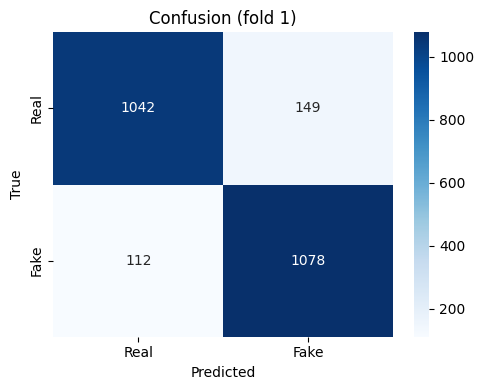

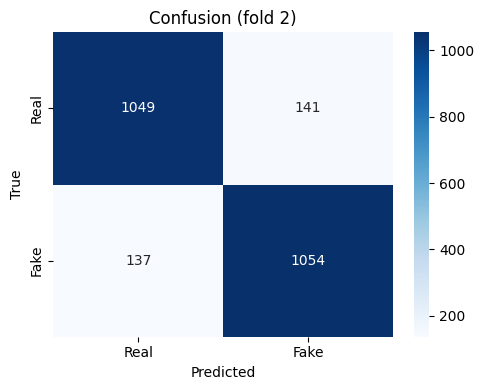

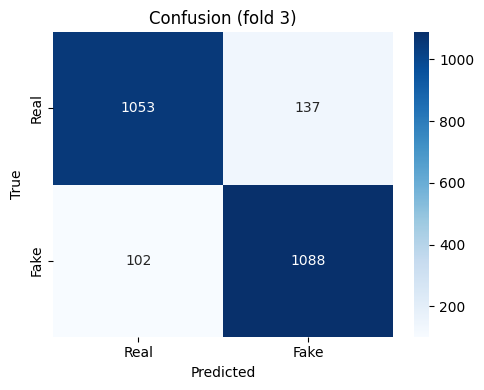

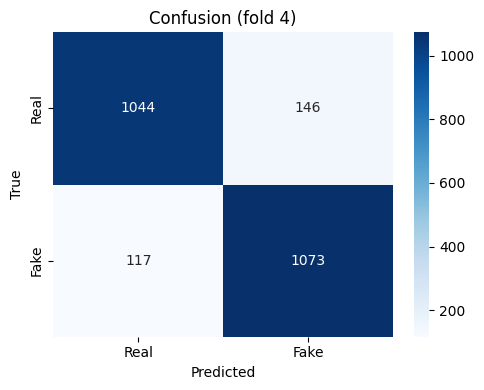

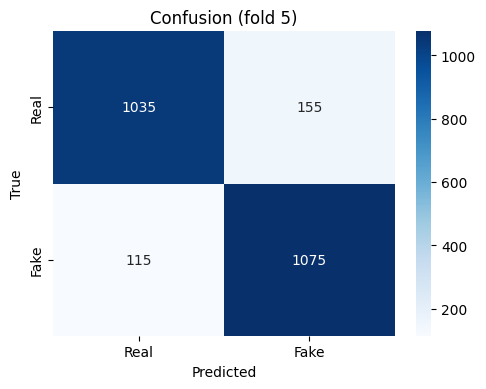


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.890382   0.878566  0.905882  0.892015  0.296293
1     2  0.883242   0.882008  0.884971  0.883487  0.296557
2     3  0.899580   0.888163  0.914286  0.901035  0.285834
3     4  0.889496   0.880230  0.901681  0.890826  0.290601
4     5  0.886555   0.873984  0.903361  0.888430  0.300684

===== MÉDIAS =====
fold         3.000000
accuracy     0.889851
precision    0.880590
recall       0.902036
f1           0.891159
log_loss     0.293994
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006116
precision    0.005178
recall       0.010700
f1           0.006417
log_loss     0.005803
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
# tfidf 1000 tokens
result = evaluate_model_cv(model, X, y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer(max_features=1000)
X = vectorizer.fit_transform(fr['text'])
print(vectorizer.get_feature_names_out())
print(X.toarray())

['00' '000' '10' '11' '12' '13' '15' '18' '19' '1º' '20' '2019' '2020'
 '2021' '30' 'abaixar' 'abril' 'abrir' 'acabar' 'acao' 'aceitar' 'acesso'
 'achar' 'acima' 'acoes' 'acompanhar' 'acontecer' 'acordar' 'acordo'
 'acreditar' 'acrescentar' 'acusar' 'adotar' 'advogar' 'aereo' 'aeroporto'
 'afastar' 'afetar' 'afirmacao' 'afirmar' 'afp' 'agencia' 'agendar'
 'agente' 'aglomeracao' 'agostar' 'agua' 'ainda' 'ajudar' 'alcool'
 'alegacao' 'alegar' 'alemanha' 'alertar' 'alexandre' 'alguir' 'algum'
 'alimento' 'alto' 'alvo' 'amazonia' 'ambientar' 'ameacar' 'americano'
 'amigo' 'analisar' 'analise' 'andar' 'ano' 'anterior' 'antes' 'antigo'
 'anunciar' 'anuncio' 'anvisar' 'aparecer' 'apenas' 'apesar' 'aplicar'
 'aplicativo' 'apo' 'apoiador' 'apoiar' 'apontar' 'apresentar' 'aprovacao'
 'aprovar' 'apurar' 'ar' 'argentino' 'armar' 'artigo' 'assinar'
 'associacao' 'assumir' 'assunto' 'atacar' 'atar' 'ate' 'atencao'
 'atender' 'atendimento' 'atingir' 'atividade' 'ato' 'atribuir' 'atual'
 'atualmente' 

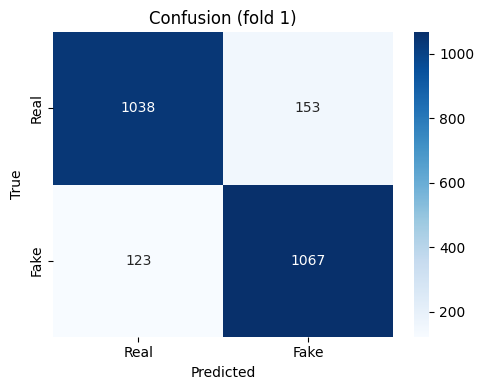

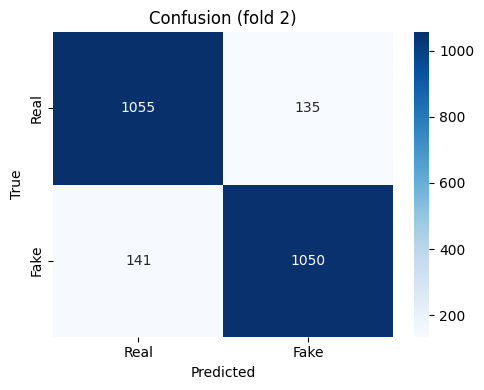

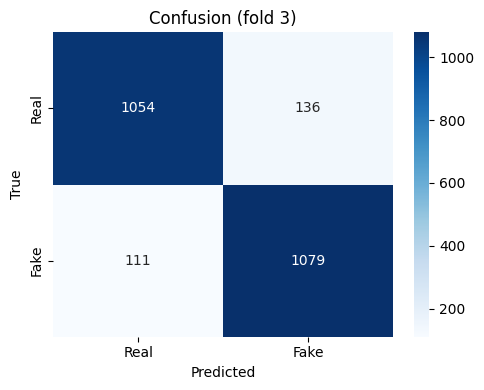

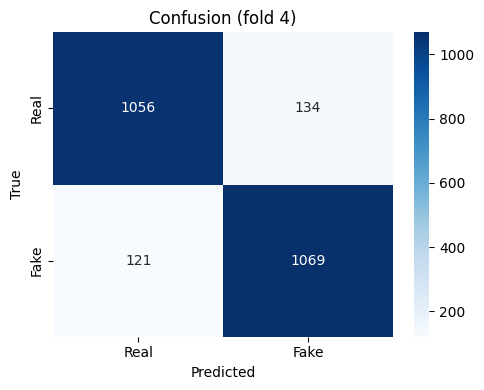

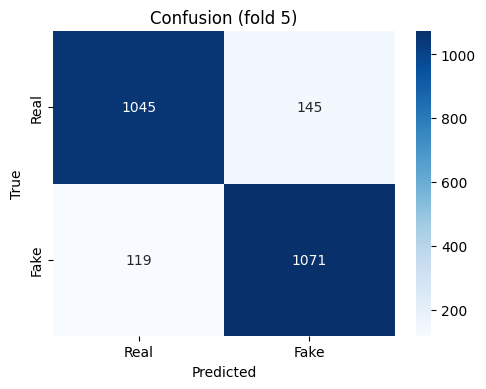


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.884082   0.874590  0.896639  0.885477  0.794295
1     2  0.884082   0.886076  0.881612  0.883838  0.805894
2     3  0.896218   0.888066  0.906723  0.897297  0.740899
3     4  0.892857   0.888612  0.898319  0.893439  0.797779
4     5  0.889076   0.880757  0.900000  0.890274  0.797530

===== MÉDIAS =====
fold         3.000000
accuracy     0.889263
precision    0.883620
recall       0.896659
f1           0.890065
log_loss     0.787279
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005362
precision    0.005926
recall       0.009241
f1           0.005558
log_loss     0.026278
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
# countvertorizer 1000 tokens
result = evaluate_model_cv(model, X, y)

## Teste com 256 tokens

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=256)
X = vectorizer.fit_transform(fr['text'])
print(vectorizer.get_feature_names_out())
print(X.toarray())

['19' '2020' 'abril' 'abrir' 'acabar' 'acao' 'acompanhar' 'acontecer'
 'acordar' 'afirmar' 'agencia' 'ajudar' 'alertar' 'algum' 'alto'
 'americano' 'amigo' 'ano' 'anunciar' 'aparecer' 'apo' 'apresentar'
 'aprovar' 'aumentar' 'autoridade' 'bolsonaro' 'brasil' 'brasileiro'
 'camar' 'campanha' 'candidato' 'casar' 'caso' 'causar' 'cercar' 'chamar'
 'chegar' 'chino' 'cidade' 'circular' 'colocar' 'combater' 'comecar'
 'compartilhar' 'comprar' 'confirmar' 'conseguir' 'considerar' 'contar'
 'continuar' 'contra' 'coronavirus' 'covid' 'crianca' 'criar' 'crise' 'de'
 'decisao' 'defender' 'deixar' 'deputar' 'descobrir' 'desde' 'dever' 'dia'
 'dinheiro' 'direito' 'divulgar' 'dizer' 'doenca' 'doencar' 'dor' 'dose'
 'durante' 'economia' 'eleicao' 'eleitoral' 'em' 'empresar' 'encontrar'
 'entanto' 'entrar' 'entrevisto' 'enviar' 'equipar' 'especialista'
 'estadual' 'estudar' 'eua' 'evento' 'evitar' 'ex' 'existir' 'explicar'
 'facebook' 'fake' 'falar' 'falso' 'familia' 'fato' 'fazer' 'fechar'
 'federal'

### Naive Bayes

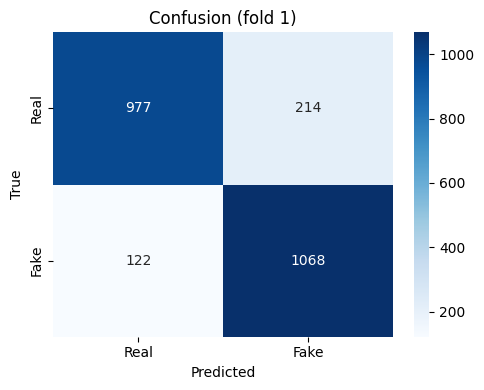

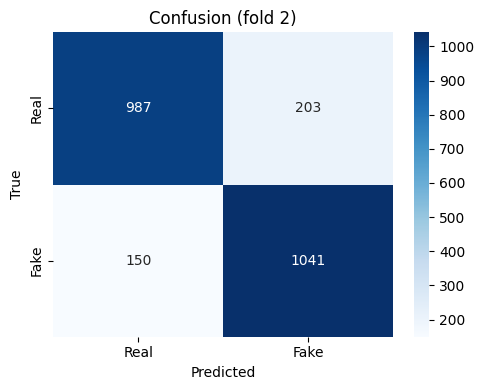

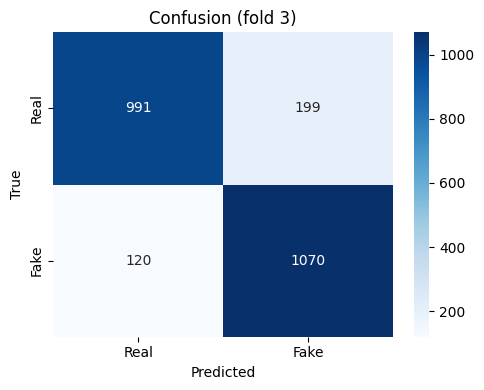

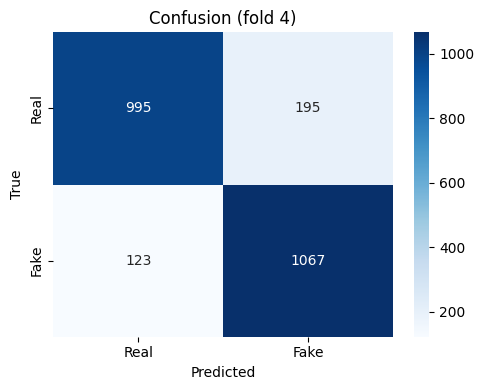

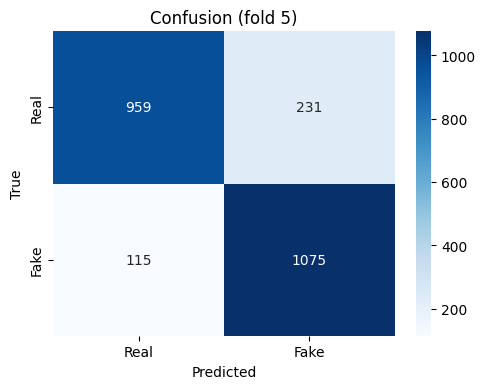


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.858883   0.833073  0.897479  0.864078  0.355501
1     2  0.851743   0.836817  0.874055  0.855031  0.350408
2     3  0.865966   0.843184  0.899160  0.870272  0.339145
3     4  0.866387   0.845483  0.896639  0.870310  0.342529
4     5  0.854622   0.823124  0.903361  0.861378  0.359872

===== MÉDIAS =====
fold         3.000000
accuracy     0.859520
precision    0.836336
recall       0.894139
f1           0.864214
log_loss     0.349491
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006588
precision    0.008888
recall       0.011522
f1           0.006447
log_loss     0.008664
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
result = evaluate_model_cv(model, X, y)

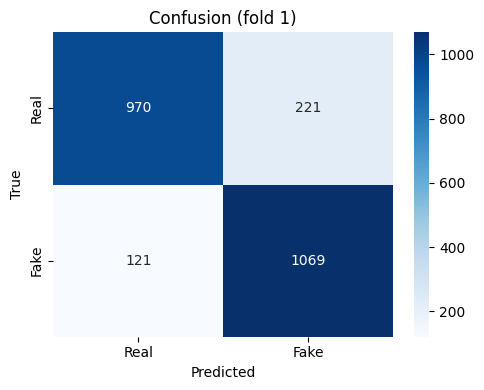

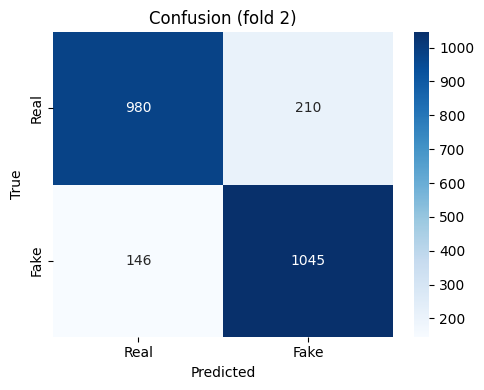

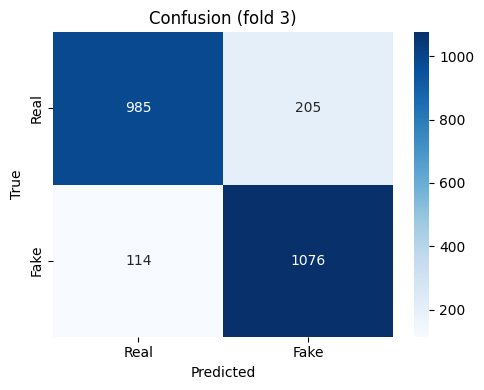

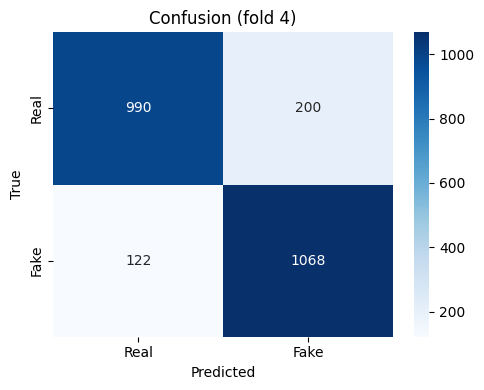

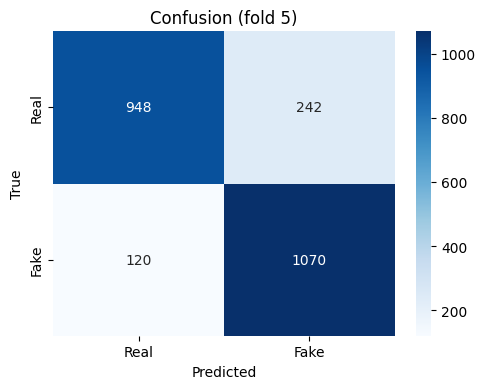


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.856363   0.828682  0.898319  0.862097  0.376132
1     2  0.850483   0.832669  0.877414  0.854456  0.370660
2     3  0.865966   0.839969  0.904202  0.870902  0.361966
3     4  0.864706   0.842271  0.897479  0.868999  0.363482
4     5  0.847899   0.815549  0.899160  0.855316  0.379154

===== MÉDIAS =====
fold         3.000000
accuracy     0.857083
precision    0.831828
recall       0.895315
f1           0.862354
log_loss     0.370279
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.008146
precision    0.010618
recall       0.010343
f1           0.007570
log_loss     0.007558
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=10)
result = evaluate_model_cv(model, X, y)

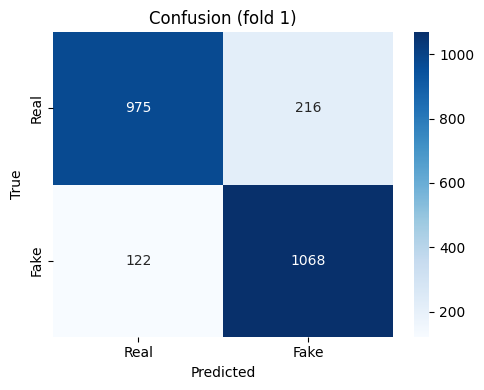

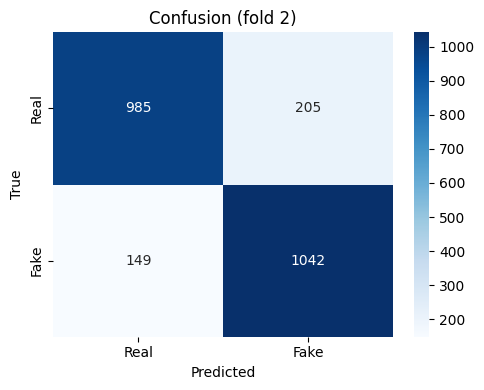

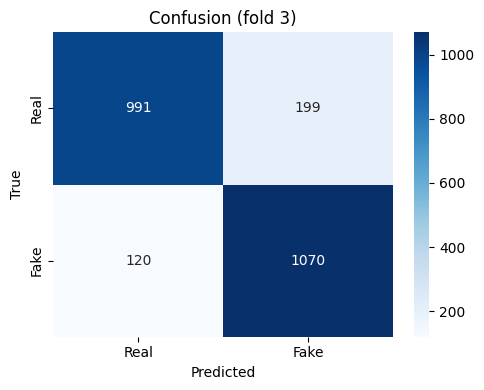

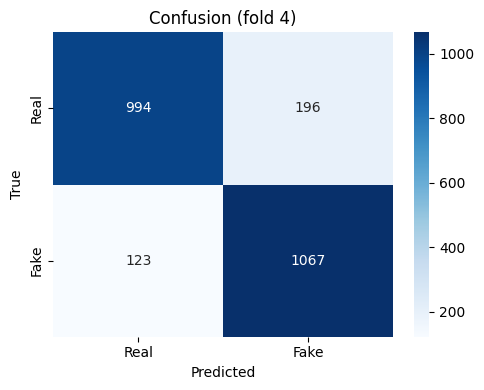

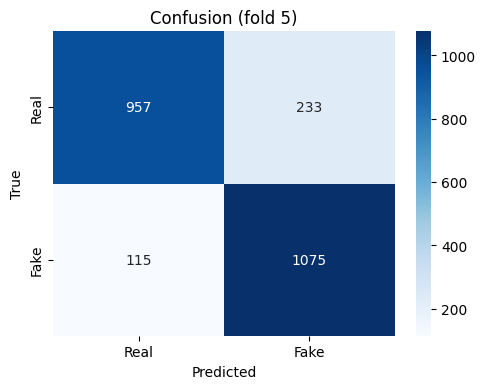


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.858043   0.831776  0.897479  0.863379  0.358233
1     2  0.851323   0.835605  0.874895  0.854799  0.352999
2     3  0.865966   0.843184  0.899160  0.870272  0.342144
3     4  0.865966   0.844814  0.896639  0.869955  0.345259
4     5  0.853782   0.821865  0.903361  0.860689  0.362410

===== MÉDIAS =====
fold         3.000000
accuracy     0.859016
precision    0.835449
recall       0.894307
f1           0.863819
log_loss     0.352209
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006785
precision    0.009295
recall       0.011156
f1           0.006532
log_loss     0.008523
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=2)
result = evaluate_model_cv(model, X, y)

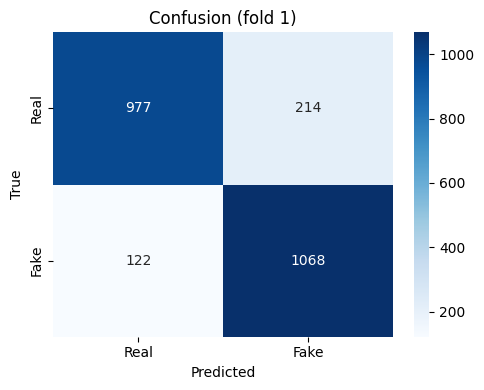

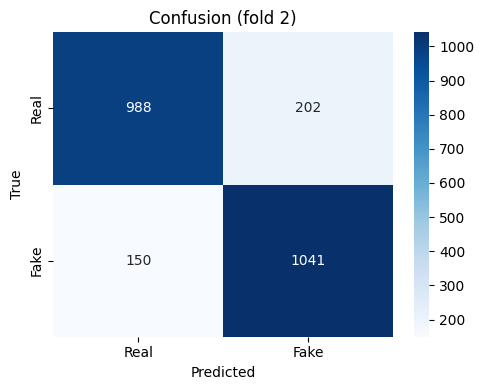

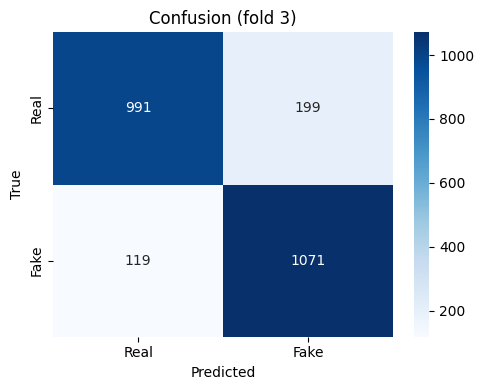

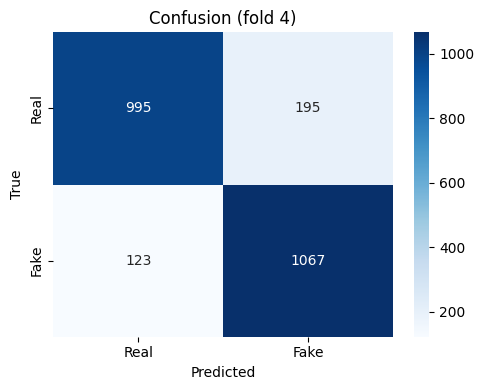

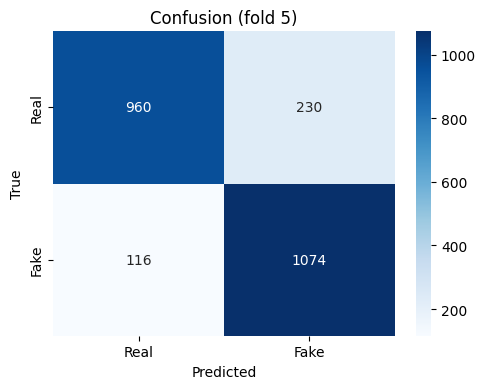


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.858883   0.833073  0.897479  0.864078  0.353923
1     2  0.852163   0.837490  0.874055  0.855382  0.348972
2     3  0.866387   0.843307  0.900000  0.870732  0.337449
3     4  0.866387   0.845483  0.896639  0.870310  0.340967
4     5  0.854622   0.823620  0.902521  0.861267  0.358403

===== MÉDIAS =====
fold         3.000000
accuracy     0.859688
precision    0.836595
recall       0.894139
f1           0.864354
log_loss     0.347943
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006570
precision    0.008741
recall       0.011460
f1           0.006447
log_loss     0.008732
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB(alpha=0.5)
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/usr/local/lib/python3.12/dist-packages/sklearn/naive_bayes.py:898: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(


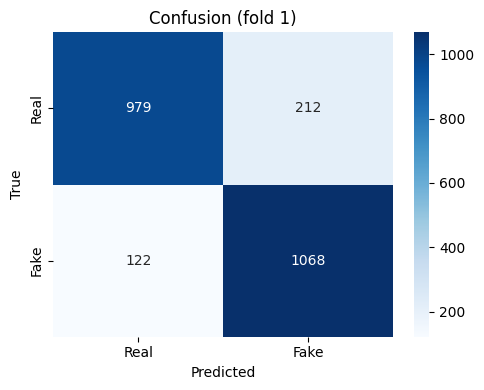

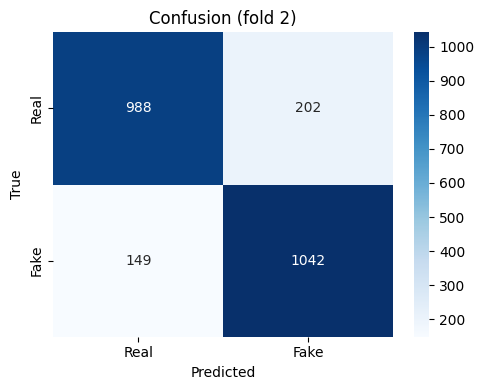

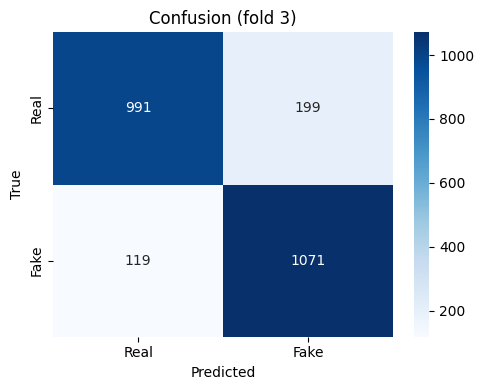

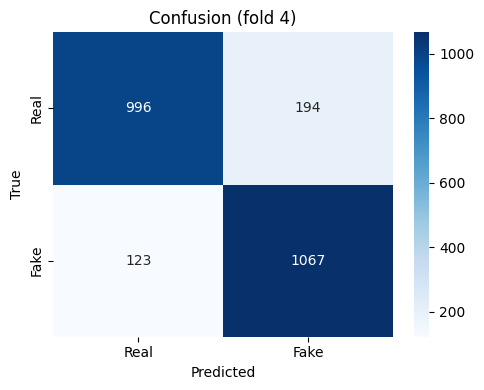

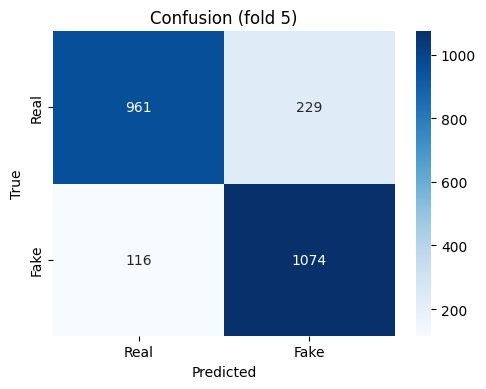


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.859723   0.834375  0.897479  0.864777  0.349788
1     2  0.852583   0.837621  0.874895  0.855852  0.345896
2     3  0.866387   0.843307  0.900000  0.870732  0.333540
3     4  0.866807   0.846154  0.896639  0.870665  0.336635
4     5  0.855042   0.824252  0.902521  0.861613  0.353853

===== MÉDIAS =====
fold         3.000000
accuracy     0.860108
precision    0.837142
recall       0.894307
f1           0.864728
log_loss     0.343942
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006456
precision    0.008563
recall       0.011093
f1           0.006320
log_loss     0.008629
dtype: float64


In [ ]:
from sklearn.naive_bayes import MultinomialNB
# melhor nb
model = MultinomialNB(alpha=0, force_alpha=True)
result = evaluate_model_cv(model, X, y)

### Multi-Layer Perceptron

In [ ]:
"""
Key Default Parameters for MLPClassifier:

    hidden_layer_sizes:
    (100,)
        This specifies a single hidden layer with 100 neurons. You can customize this to include more layers and different numbers of neurons per layer (e.g., (50, 20) for two hidden layers with 50 and 20 neurons, respectively).
    activation:
    'relu'
        The rectified linear unit (ReLU) activation function is used by default in the hidden layers. Other options include 'logistic' (sigmoid), 'tanh' (hyperbolic tangent), and 'identity'.
    solver:
    'adam'
        The Adam optimizer is the default algorithm for weight optimization. Alternatives are 'lbfgs' and 'sgd' (stochastic gradient descent).
    alpha:
    0.0001
        This is the L2 penalty (regularization term) parameter, used to prevent overfitting.
    batch_size:
    'auto'
        When using stochastic optimizers like Adam or SGD, 'auto' sets batch_size to the minimum of 200 or n_samples.
    learning_rate_init:
    0.001
        This is the initial learning rate used by the Adam and SGD solvers.
    max_iter:
    200
        The maximum number of iterations (epochs) the solver will run.
    random_state:
    None
        Used for reproducibility. Setting this to an integer will ensure the same random initialization and data shuffling across runs.
    tol:
    1e-4
        Tolerance for the optimization. The training will stop if the loss improvement is less than this value.
    early_stopping:
    False
        By default, early stopping is not enabled. If set to True, training will terminate if the validation score does not improve for n_iter_no_change consecutive iterations.
    validation_fraction:
    0.1
        The proportion of training data to set aside as a validation set when early_stopping is True.
    n_iter_no_change:
    10
        Maximum number of iterations without improvement to wait before early stopping.
"""

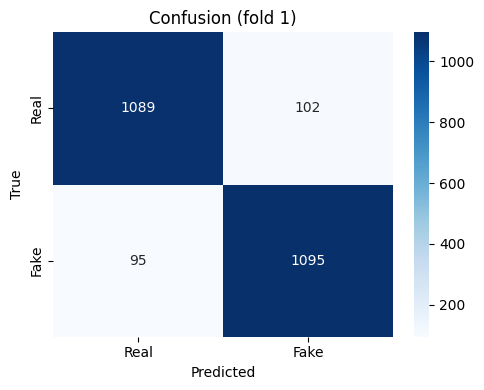

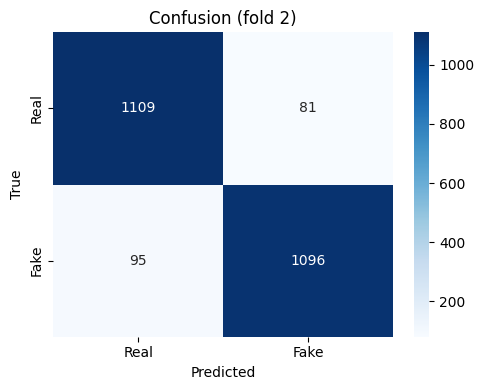

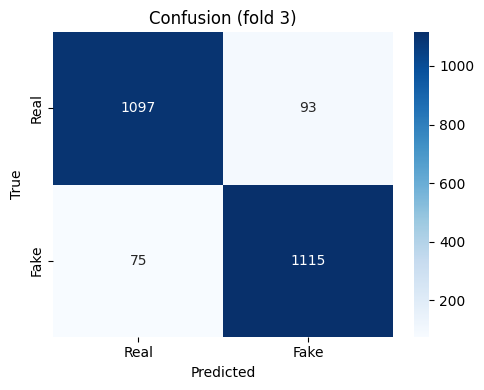

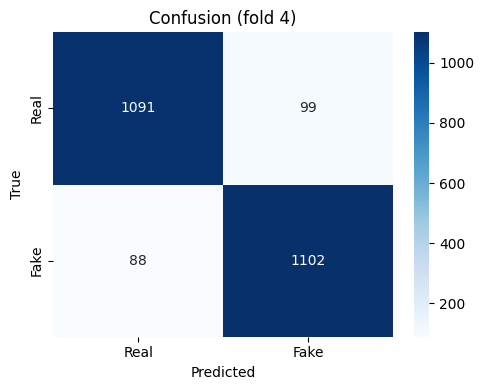

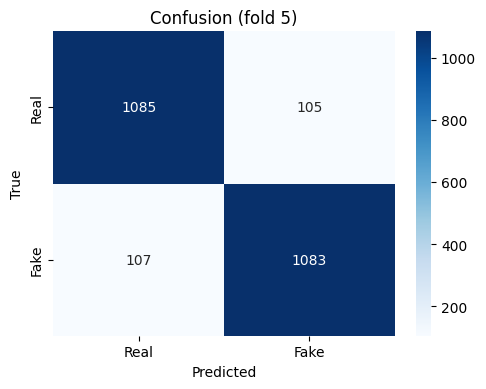


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.917262   0.914787  0.920168  0.917470  0.354578
1     2  0.926081   0.931181  0.920235  0.925676  0.329050
2     3  0.929412   0.923013  0.936975  0.929942  0.277954
3     4  0.921429   0.917569  0.926050  0.921790  0.329701
4     5  0.910924   0.911616  0.910084  0.910849  0.337232

===== MÉDIAS =====
fold         3.000000
accuracy     0.921022
precision    0.919633
recall       0.922702
f1           0.921145
log_loss     0.325703
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.007284
precision    0.007694
recall       0.009832
f1           0.007380
log_loss     0.028609
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
result = evaluate_model_cv(model, X, y)

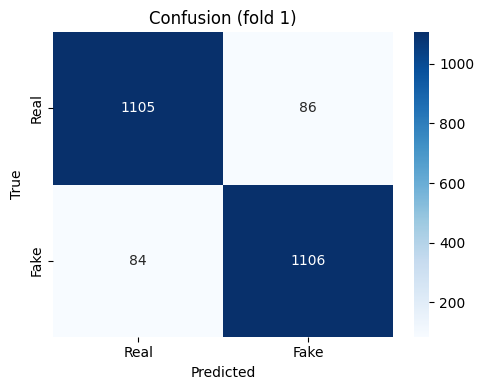

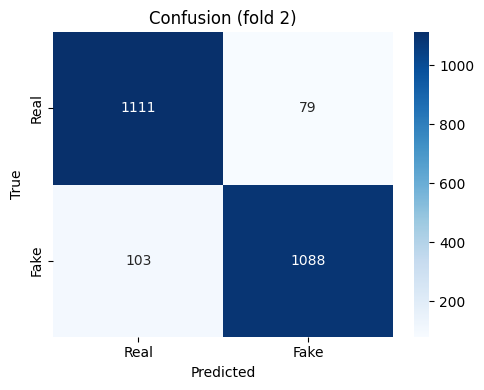

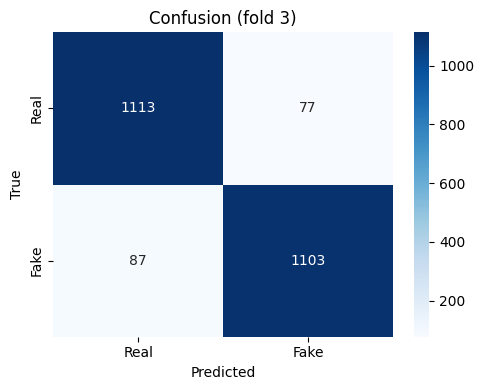

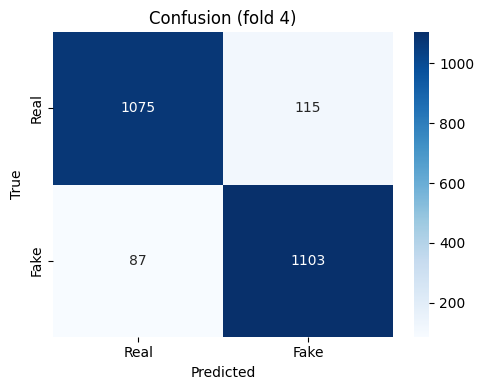

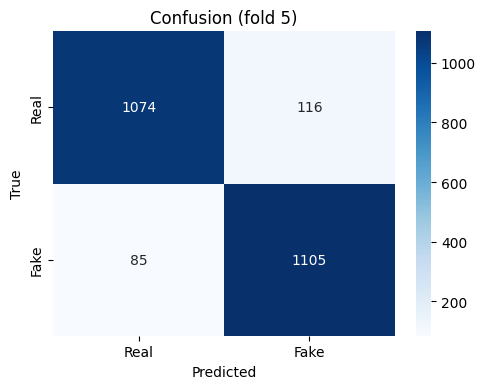


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.928601   0.927852  0.929412  0.928631  0.243846
1     2  0.923562   0.932305  0.913518  0.922816  0.233779
2     3  0.931092   0.934746  0.926891  0.930802  0.206445
3     4  0.915126   0.905583  0.926891  0.916113  0.254718
4     5  0.915546   0.904996  0.928571  0.916632  0.266853

===== MÉDIAS =====
fold         3.000000
accuracy     0.922786
precision    0.921096
recall       0.925057
f1           0.922999
log_loss     0.241128
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.007323
precision    0.014641
recall       0.006542
f1           0.006719
log_loss     0.022972
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier
# melhor MLP
model = MLPClassifier(hidden_layer_sizes=(256), max_iter=400, alpha=0.01)
result = evaluate_model_cv(model, X, y)

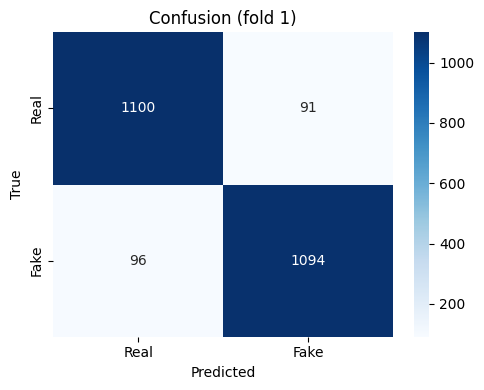

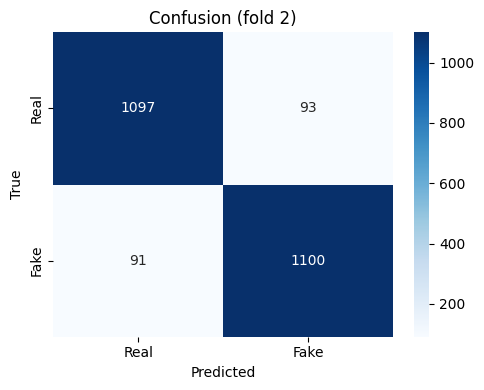

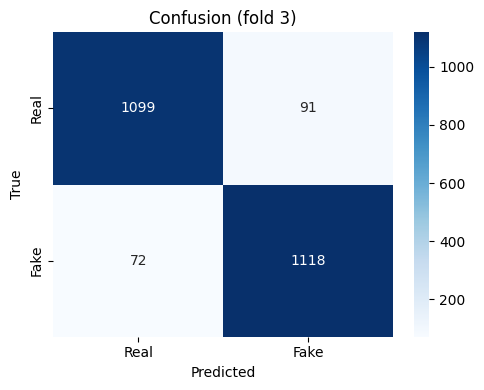

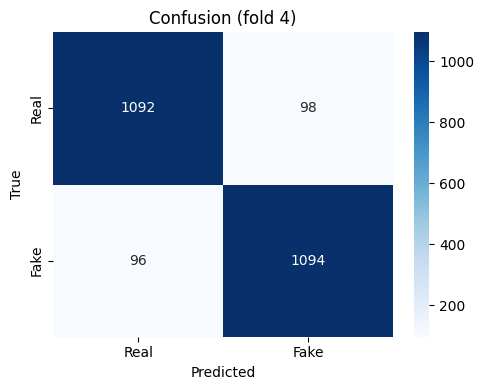

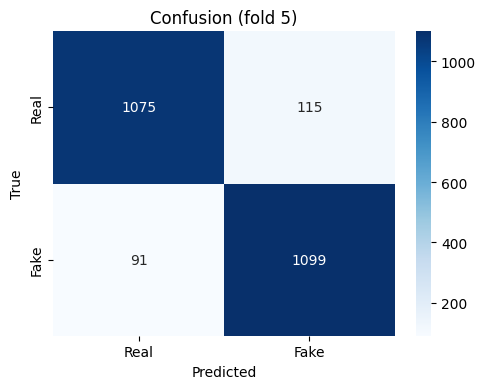


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.921462   0.923207  0.919328  0.921263  0.326338
1     2  0.922722   0.922045  0.923594  0.922819  0.322684
2     3  0.931513   0.924731  0.939496  0.932055  0.278786
3     4  0.918487   0.917785  0.919328  0.918556  0.325137
4     5  0.913445   0.905272  0.923529  0.914309  0.342519

===== MÉDIAS =====
fold         3.000000
accuracy     0.921526
precision    0.918608
recall       0.925055
f1           0.921800
log_loss     0.319093
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006628
precision    0.007890
recall       0.008346
f1           0.006579
log_loss     0.023850
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256), max_iter=300)
result = evaluate_model_cv(model, X, y)

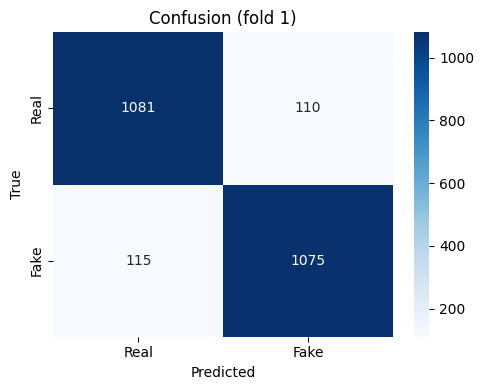

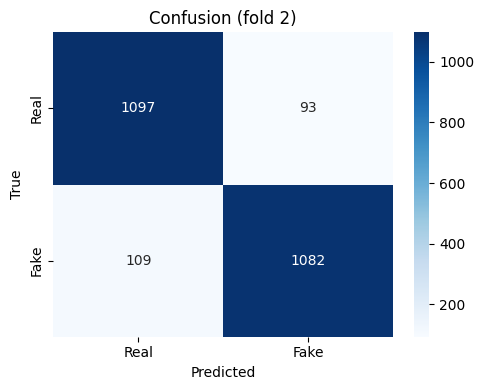

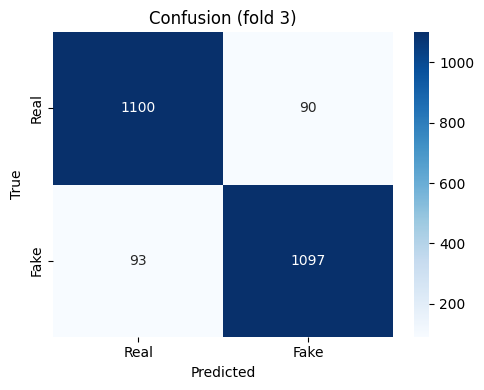

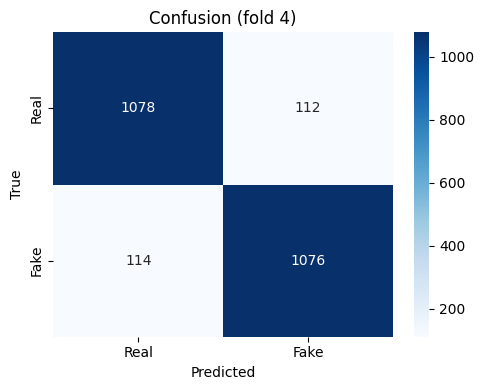

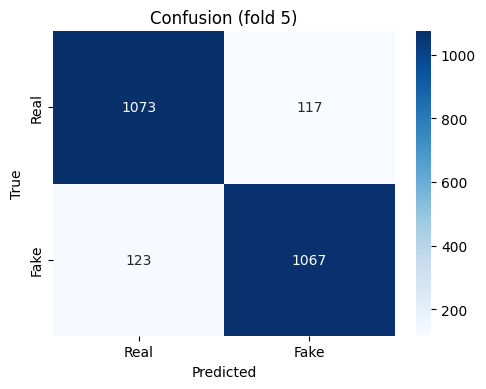


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.905502   0.907173  0.903361  0.905263  0.698715
1     2  0.915162   0.920851  0.908480  0.914624  0.570173
2     3  0.923109   0.924179  0.921849  0.923012  0.484098
3     4  0.905042   0.905724  0.904202  0.904962  0.666126
4     5  0.899160   0.901182  0.896639  0.898905  0.704170

===== MÉDIAS =====
fold         3.000000
accuracy     0.909595
precision    0.911822
recall       0.906906
f1           0.909353
log_loss     0.624656
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.009487
precision    0.010077
recall       0.009368
f1           0.009481
log_loss     0.095199
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256), alpha=0.01, solver="lbfgs")
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

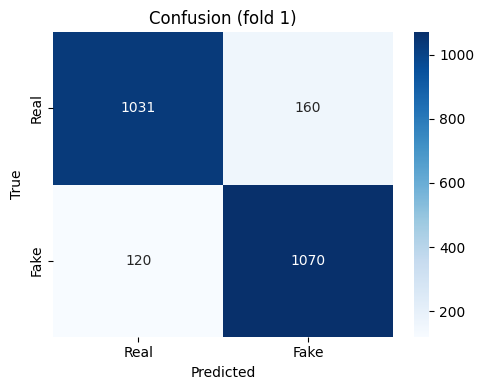

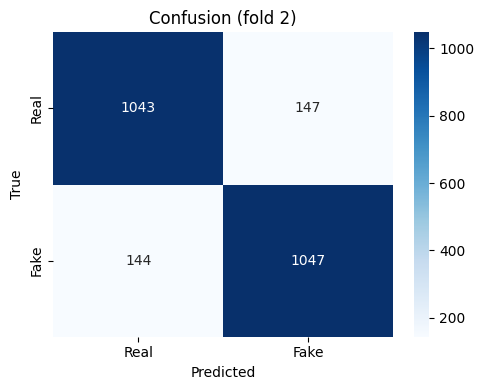

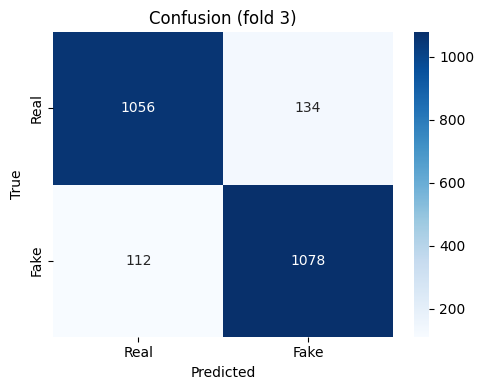

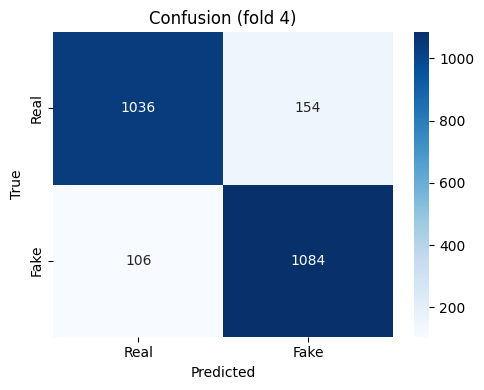

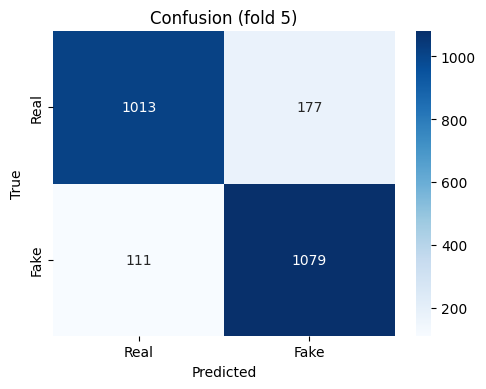


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.882402   0.869919  0.899160  0.884298  0.293282
1     2  0.877782   0.876884  0.879093  0.877987  0.288488
2     3  0.896639   0.889439  0.905882  0.897585  0.278148
3     4  0.890756   0.875606  0.910924  0.892916  0.284876
4     5  0.878992   0.859076  0.906723  0.882257  0.296738

===== MÉDIAS =====
fold         3.000000
accuracy     0.885314
precision    0.874185
recall       0.900356
f1           0.887009
log_loss     0.288307
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.008109
precision    0.011051
recall       0.012613
f1           0.008032
log_loss     0.007260
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256), alpha=0.01, solver="sgd")
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

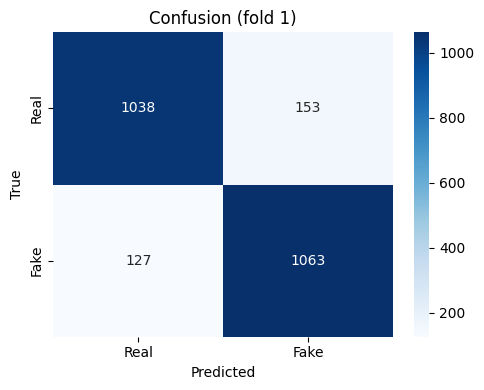

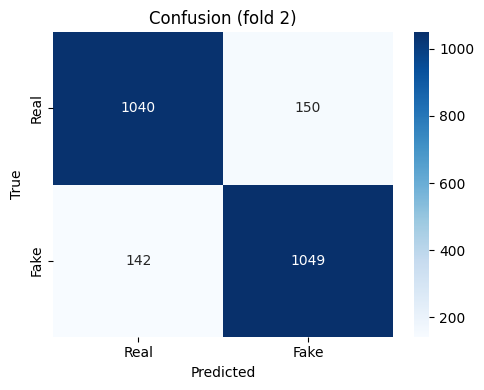

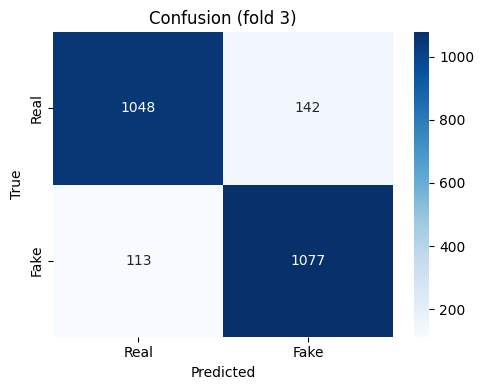

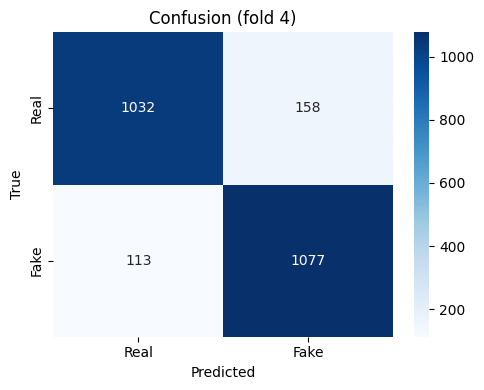

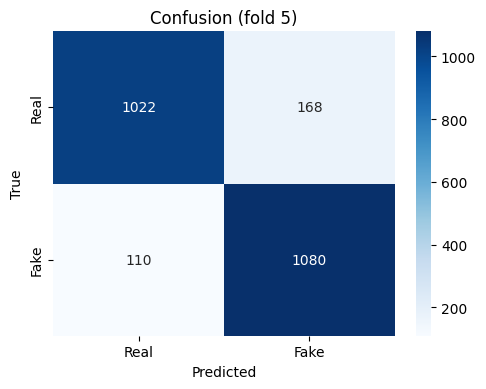


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.882402   0.874178  0.893277  0.883624  0.296011
1     2  0.877362   0.874896  0.880772  0.877824  0.290403
2     3  0.892857   0.883511  0.905042  0.894147  0.275507
3     4  0.886134   0.872065  0.905042  0.888247  0.284586
4     5  0.883193   0.865385  0.907563  0.885972  0.295444

===== MÉDIAS =====
fold         3.000000
accuracy     0.884390
precision    0.874007
recall       0.898339
f1           0.885963
log_loss     0.288390
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005690
precision    0.006505
recall       0.011282
f1           0.005998
log_loss     0.008549
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256), alpha=0.005, solver="sgd")
result = evaluate_model_cv(model, X, y)

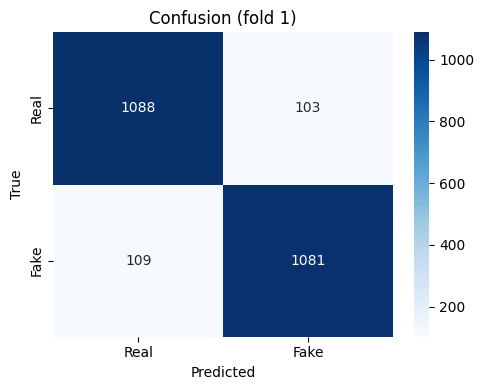

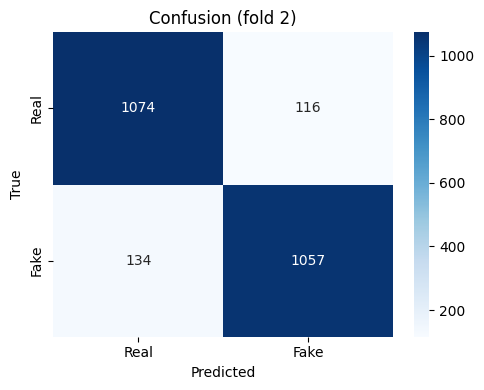

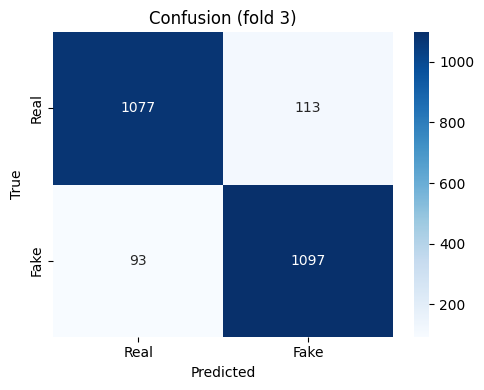

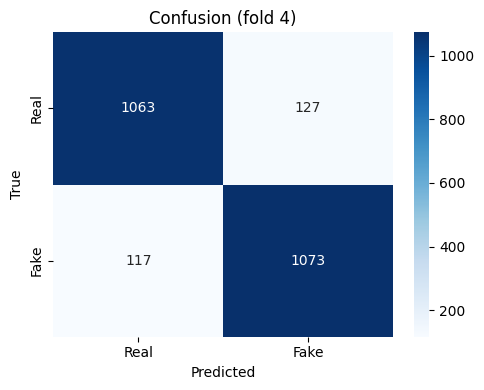

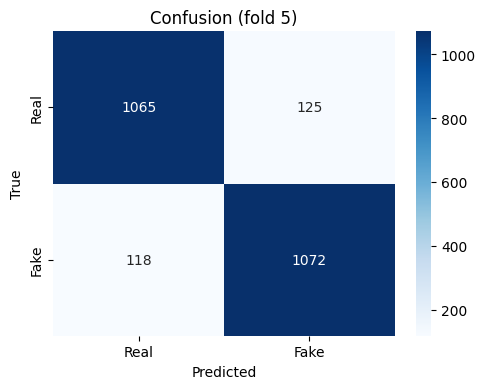


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.910962   0.913007  0.908403  0.910699  0.429104
1     2  0.895002   0.901108  0.887490  0.894247  0.488654
2     3  0.913445   0.906612  0.921849  0.914167  0.348515
3     4  0.897479   0.894167  0.901681  0.897908  0.461473
4     5  0.897899   0.895572  0.900840  0.898199  0.498856

===== MÉDIAS =====
fold         3.000000
accuracy     0.902957
precision    0.902093
recall       0.904053
f1           0.903044
log_loss     0.445320
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.008558
precision    0.007840
recall       0.012509
f1           0.008797
log_loss     0.060496
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(64), solver="lbfgs", alpha=0.05, learning_rate_init=2e-5, max_iter=500)
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

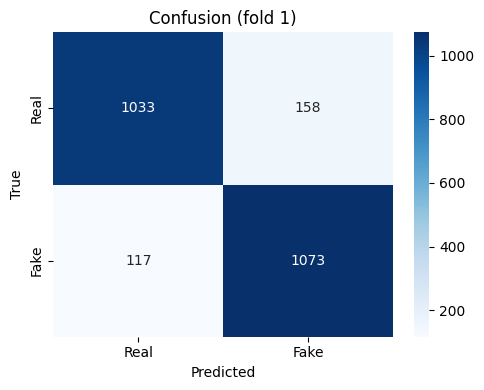

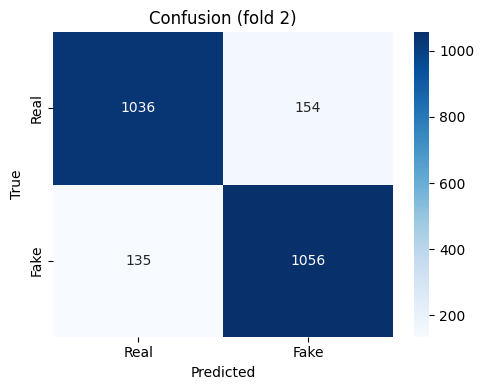

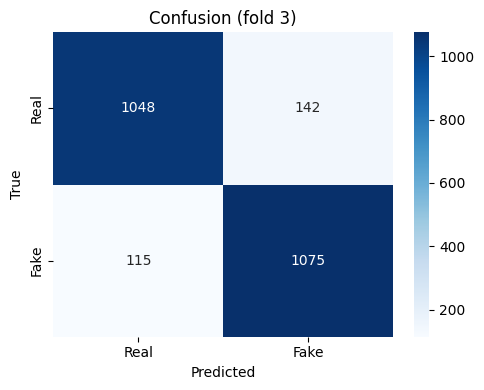

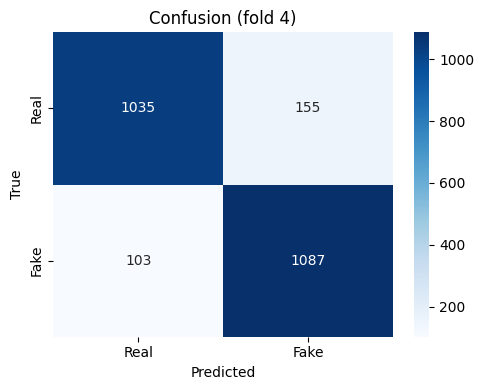

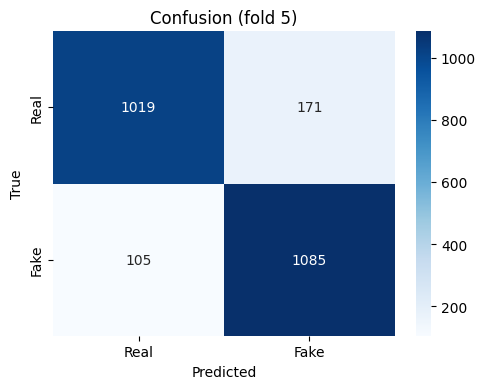


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.884502   0.871649  0.901681  0.886411  0.299603
1     2  0.878622   0.872727  0.886650  0.879633  0.291448
2     3  0.892017   0.883320  0.903361  0.893228  0.275723
3     4  0.891597   0.875201  0.913445  0.893914  0.289917
4     5  0.884034   0.863854  0.911765  0.887163  0.297468

===== MÉDIAS =====
fold         3.000000
accuracy     0.886154
precision    0.873350
recall       0.903380
f1           0.888070
log_loss     0.290832
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005656
precision    0.007005
recall       0.010658
f1           0.005821
log_loss     0.009360
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(64), alpha=0.05, learning_rate_init=2e-5)
result = evaluate_model_cv(model, X, y)

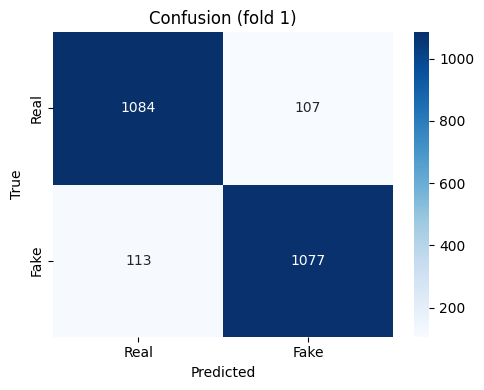

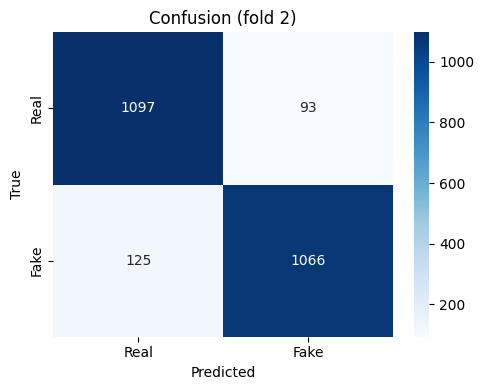

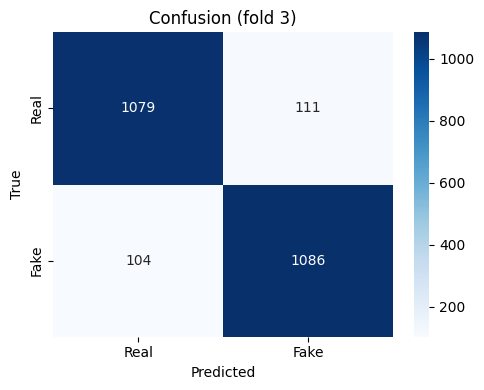

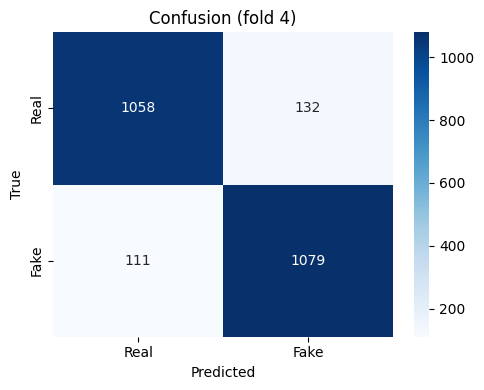

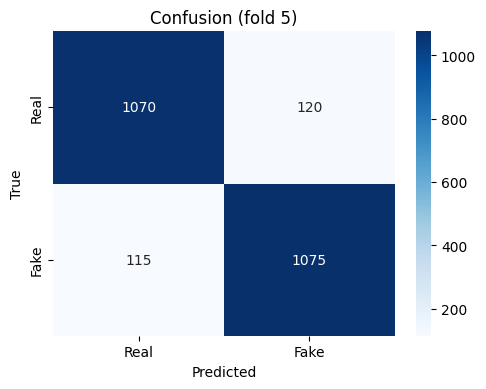


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.907602   0.909628  0.905042  0.907329  0.489961
1     2  0.908442   0.919758  0.895046  0.907234  0.484141
2     3  0.909664   0.907268  0.912605  0.909929  0.516452
3     4  0.897899   0.890999  0.906723  0.898792  0.465980
4     5  0.901261   0.899582  0.903361  0.901468  0.487958

===== MÉDIAS =====
fold         3.000000
accuracy     0.904973
precision    0.905447
recall       0.904555
f1           0.904950
log_loss     0.488898
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005118
precision    0.010825
recall       0.006356
f1           0.004629
log_loss     0.018091
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(128,64,128), alpha=0.01)
result = evaluate_model_cv(model, X, y)

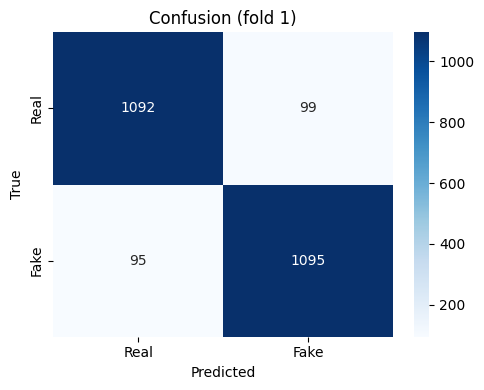

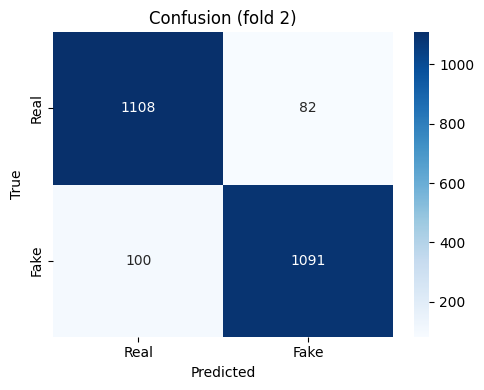

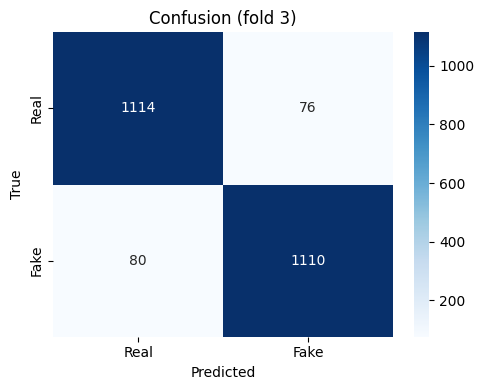

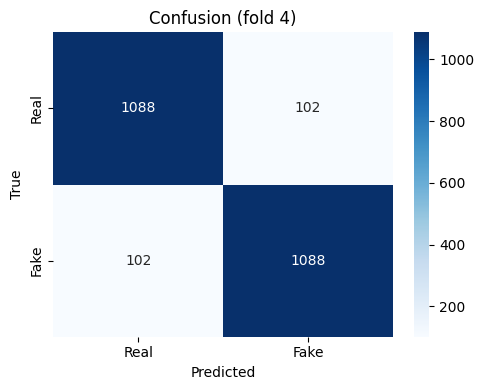

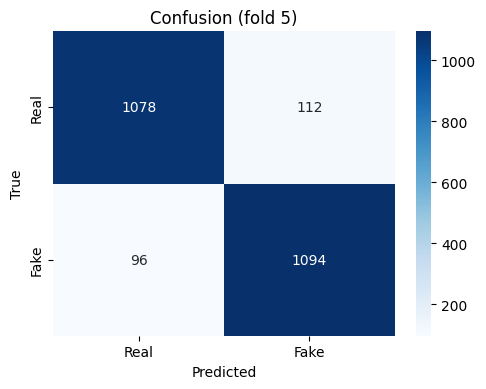


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.918522   0.917085  0.920168  0.918624  0.241281
1     2  0.923562   0.930094  0.916037  0.923012  0.240257
2     3  0.934454   0.935919  0.932773  0.934343  0.192813
3     4  0.914286   0.914286  0.914286  0.914286  0.258203
4     5  0.912605   0.907131  0.919328  0.913189  0.269835

===== MÉDIAS =====
fold         3.000000
accuracy     0.920686
precision    0.920903
recall       0.920518
f1           0.920691
log_loss     0.240478
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.008786
precision    0.011811
recall       0.007257
f1           0.008564
log_loss     0.029363
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(256), alpha=0.01)
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


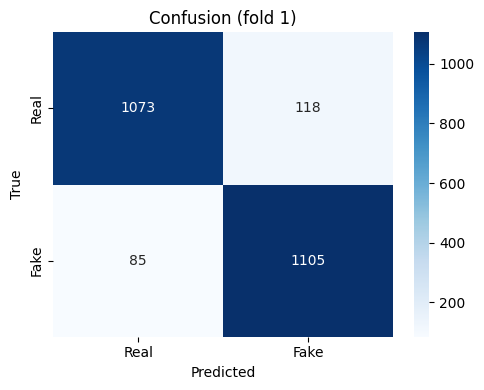

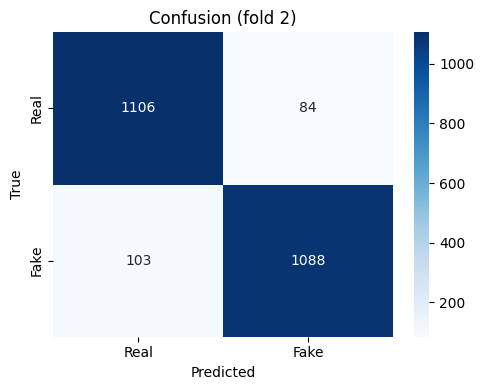

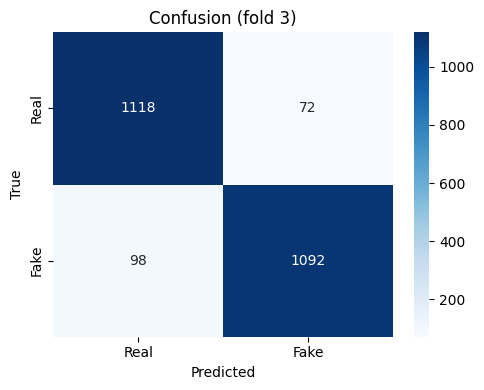

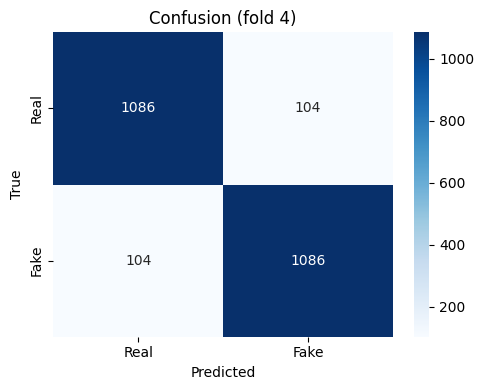

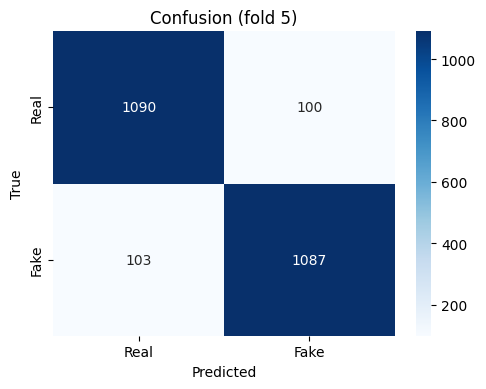


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.914742   0.903516  0.928571  0.915872  0.208238
1     2  0.921462   0.928328  0.913518  0.920863  0.205512
2     3  0.928571   0.938144  0.917647  0.927782  0.189112
3     4  0.912605   0.912605  0.912605  0.912605  0.218544
4     5  0.914706   0.915754  0.913445  0.914598  0.218524

===== MÉDIAS =====
fold         3.000000
accuracy     0.918417
precision    0.919669
recall       0.917157
f1           0.918344
log_loss     0.207986
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006585
precision    0.013624
recall       0.006676
f1           0.006093
log_loss     0.012093
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=(128), alpha=0.1)
result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptro

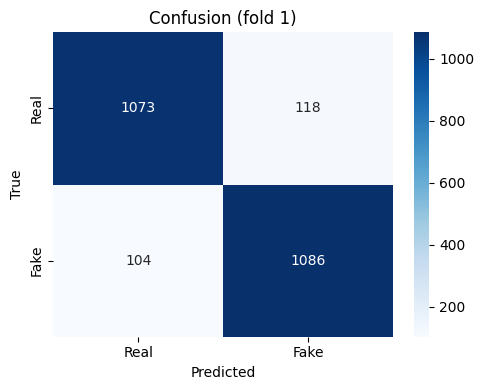

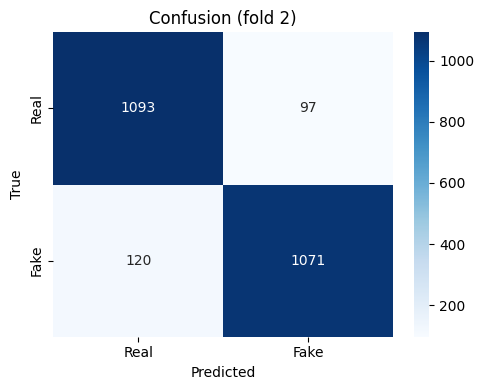

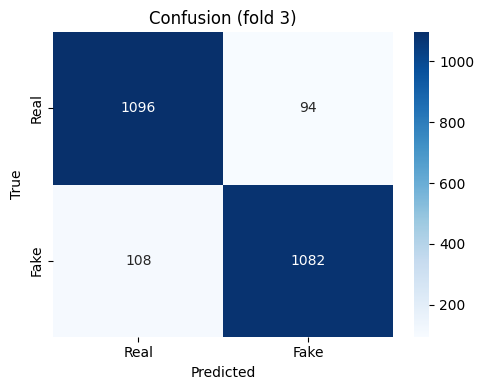

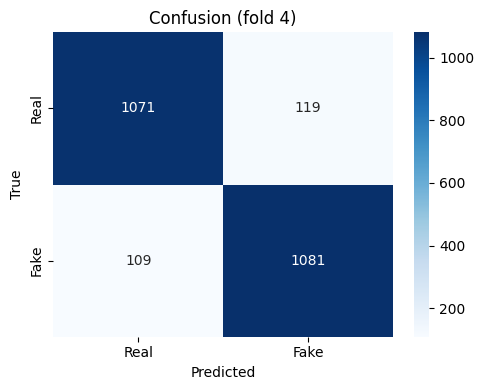

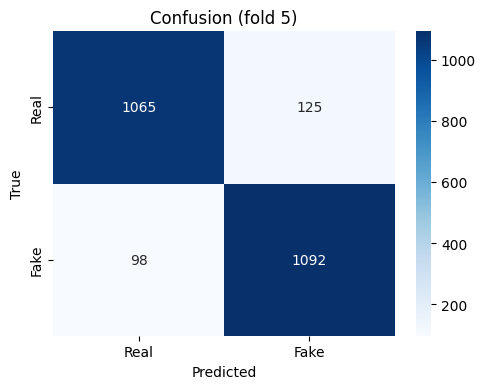


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.906762   0.901993  0.912605  0.907268  0.246530
1     2  0.908862   0.916952  0.899244  0.908012  0.231560
2     3  0.915126   0.920068  0.909244  0.914624  0.221447
3     4  0.904202   0.900833  0.908403  0.904603  0.258898
4     5  0.906303   0.897288  0.917647  0.907354  0.258619

===== MÉDIAS =====
fold         3.000000
accuracy     0.908251
precision    0.907427
recall       0.909429
f1           0.908372
log_loss     0.243411
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.004185
precision    0.010324
recall       0.006753
f1           0.003731
log_loss     0.016611
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier
#solver adam
model = MLPClassifier(hidden_layer_sizes=(128,64,128),learning_rate_init=2e-5)
result = evaluate_model_cv(model, X, y)

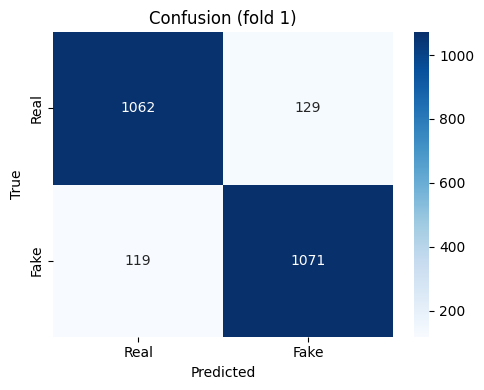

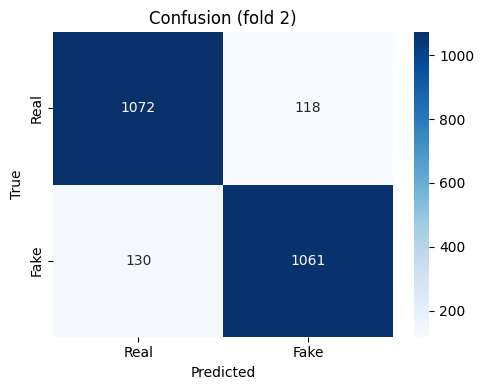

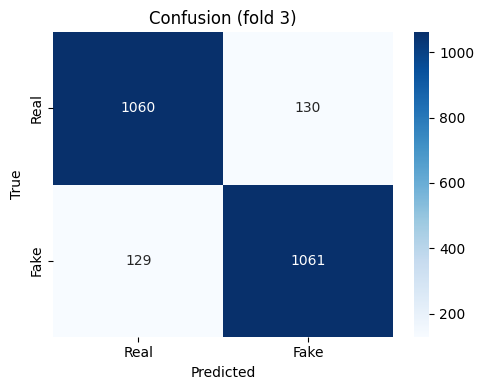

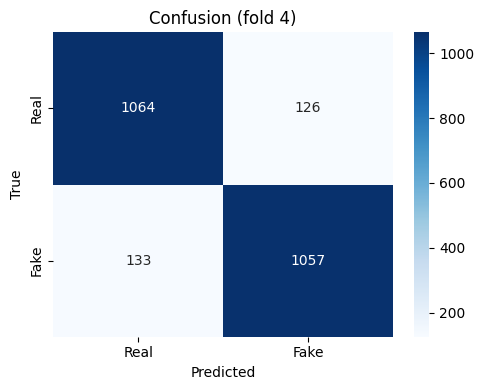

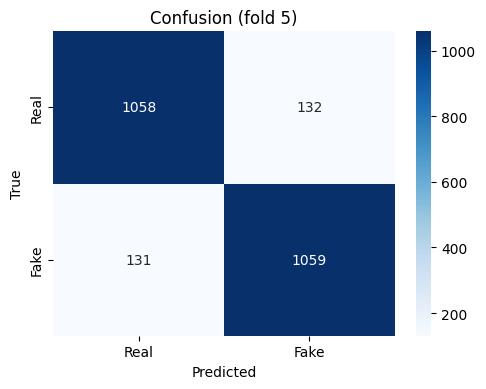


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.895842   0.892500  0.900000  0.896234  2.040076
1     2  0.895842   0.899915  0.890848  0.895359  1.787426
2     3  0.891176   0.890848  0.891597  0.891222  1.440393
3     4  0.891176   0.893491  0.888235  0.890855  1.670802
4     5  0.889496   0.889169  0.889916  0.889542  2.062011

===== MÉDIAS =====
fold         3.000000
accuracy     0.892707
precision    0.893185
recall       0.892119
f1           0.892643
log_loss     1.800142
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.002943
precision    0.004106
recall       0.004581
f1           0.002962
log_loss     0.260985
dtype: float64


In [ ]:
model = MLPClassifier(hidden_layer_sizes=(128,64,128), solver="lbfgs", learning_rate_init=2e-5, max_iter=500)
result = evaluate_model_cv(model, X, y)

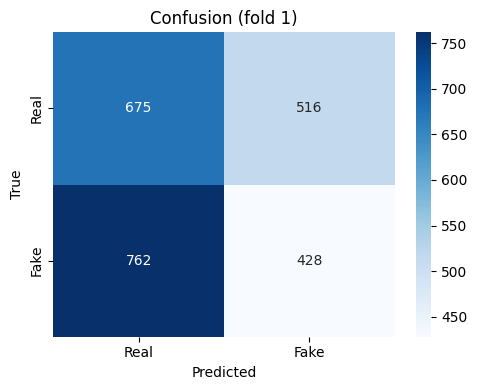

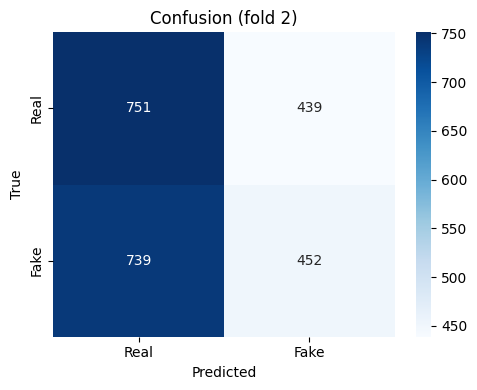

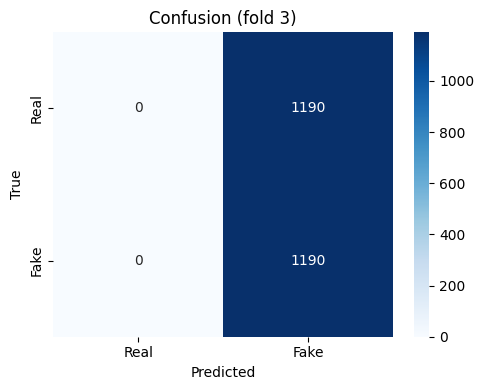

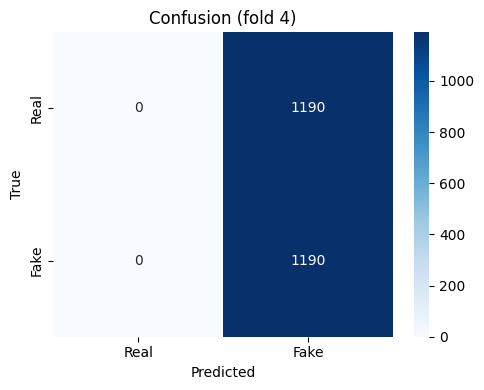

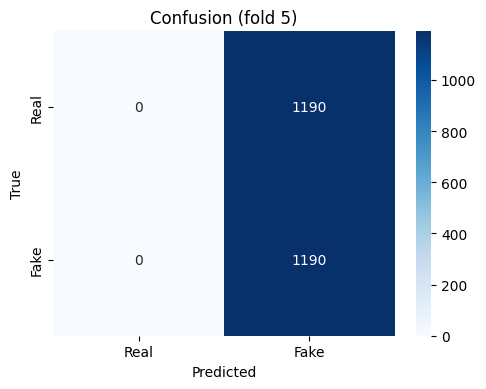


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.463251   0.453390  0.359664  0.401125  0.694923
1     2  0.505250   0.507295  0.379513  0.434198  0.693099
2     3  0.500000   0.500000  1.000000  0.666667  0.699331
3     4  0.500000   0.500000  1.000000  0.666667  0.695651
4     5  0.500000   0.500000  1.000000  0.666667  0.697646

===== MÉDIAS =====
fold         3.000000
accuracy     0.493700
precision    0.492137
recall       0.747835
f1           0.567065
log_loss     0.696130
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.017173
precision    0.021889
recall       0.345362
f1           0.136886
log_loss     0.002420
dtype: float64


In [ ]:
model = MLPClassifier(hidden_layer_sizes=(128,64,128), solver="sgd", learning_rate_init=2e-5)
result = evaluate_model_cv(model, X, y)

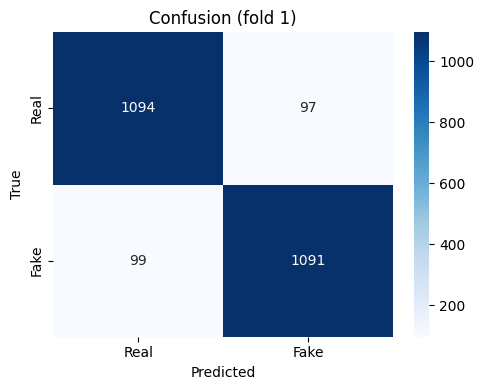

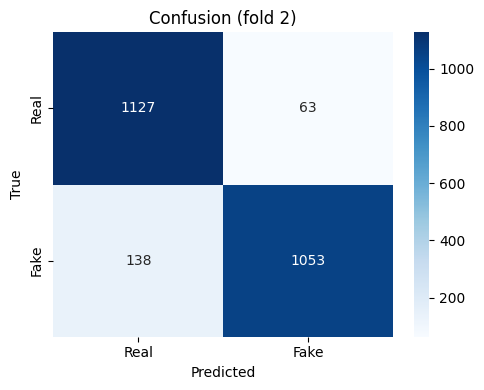

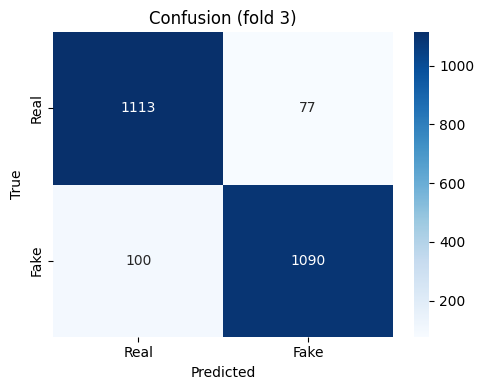

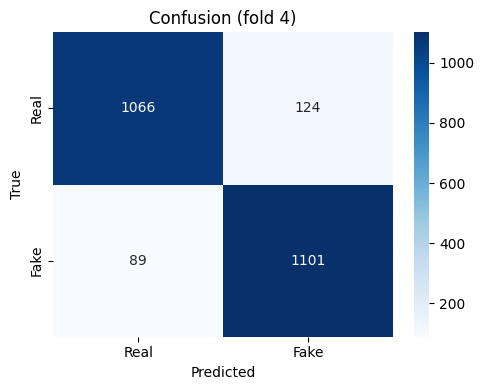

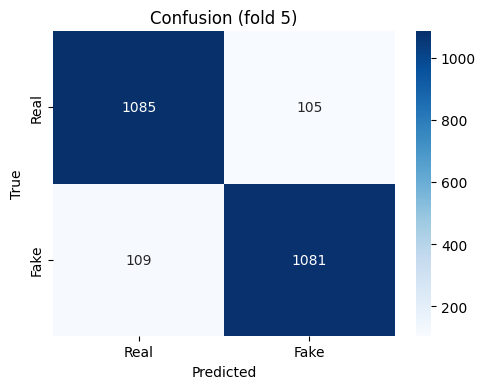


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.917682   0.918350  0.916807  0.917578  0.305041
1     2  0.915582   0.943548  0.884131  0.912874  0.326452
2     3  0.925630   0.934019  0.915966  0.924905  0.269938
3     4  0.910504   0.898776  0.925210  0.911801  0.318530
4     5  0.910084   0.911467  0.908403  0.909933  0.350209

===== MÉDIAS =====
fold         3.000000
accuracy     0.915896
precision    0.921232
recall       0.910104
f1           0.915418
log_loss     0.314034
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006342
precision    0.017815
recall       0.015692
f1           0.006006
log_loss     0.029616
dtype: float64


In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(hidden_layer_sizes=256, batch_size=8)
result = evaluate_model_cv(model, X, y)

### Random Forest

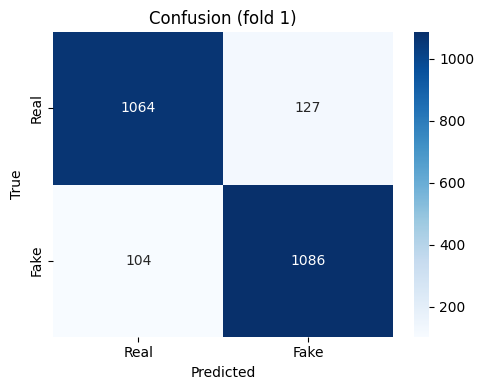

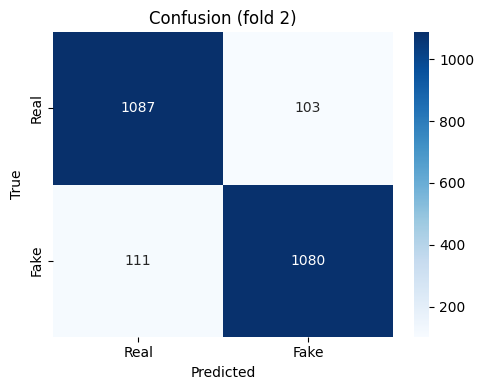

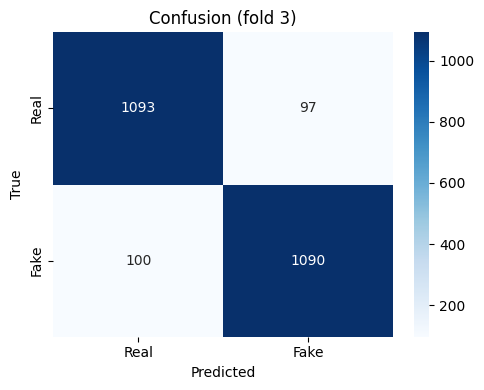

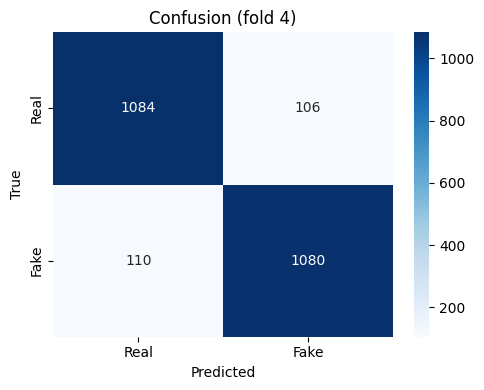

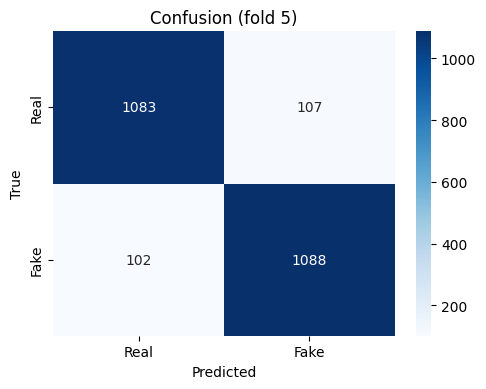


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.902982   0.895301  0.912605  0.903870  0.275532
1     2  0.910122   0.912933  0.906801  0.909857  0.272737
2     3  0.917227   0.918281  0.915966  0.917122  0.263423
3     4  0.909244   0.910624  0.907563  0.909091  0.297558
4     5  0.912185   0.910460  0.914286  0.912369  0.273685

===== MÉDIAS =====
fold         3.000000
accuracy     0.910352
precision    0.909520
recall       0.911444
f1           0.910462
log_loss     0.276587
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005153
precision    0.008554
recall       0.004077
f1           0.004840
log_loss     0.012624
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
result = evaluate_model_cv(model, X, y)

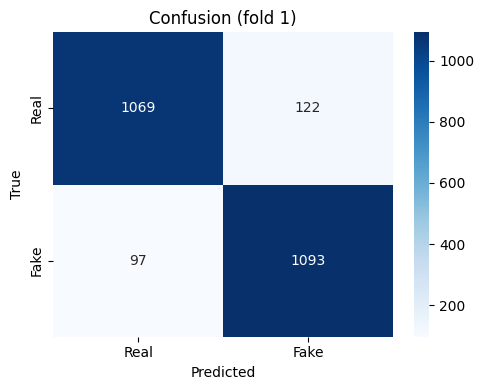

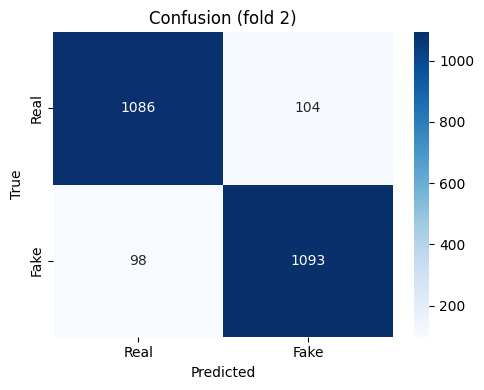

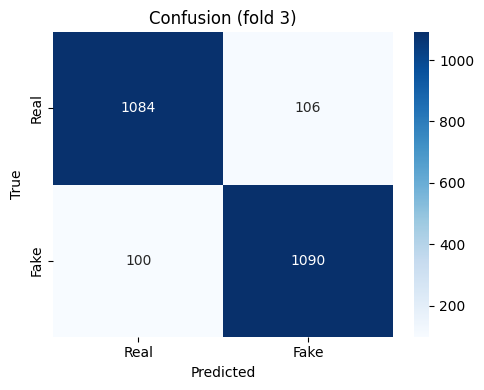

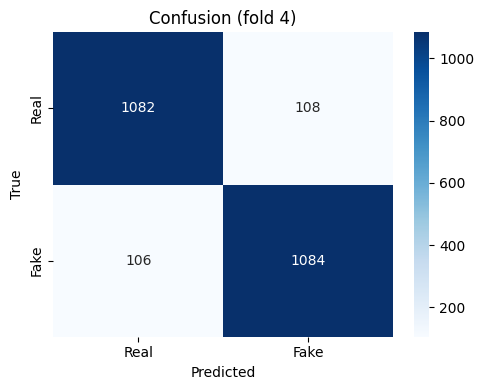

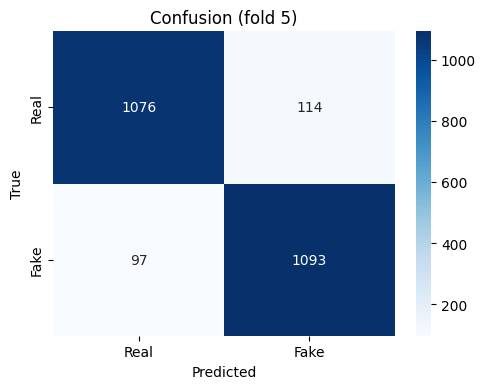


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.908022   0.899588  0.918487  0.908940  0.269460
1     2  0.915162   0.913116  0.917716  0.915410  0.255144
2     3  0.913445   0.911371  0.915966  0.913663  0.241475
3     4  0.910084   0.909396  0.910924  0.910160  0.249352
4     5  0.911345   0.905551  0.918487  0.911973  0.256093

===== MÉDIAS =====
fold         3.000000
accuracy     0.911611
precision    0.907805
recall       0.916316
f1           0.912029
log_loss     0.254305
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.002795
precision    0.005386
recall       0.003185
f1           0.002605
log_loss     0.010280
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier
# melhor rf
model = RandomForestClassifier(n_estimators=75, max_depth=64, criterion='entropy',bootstrap=False, random_state=42)
result = evaluate_model_cv(model, X, y)

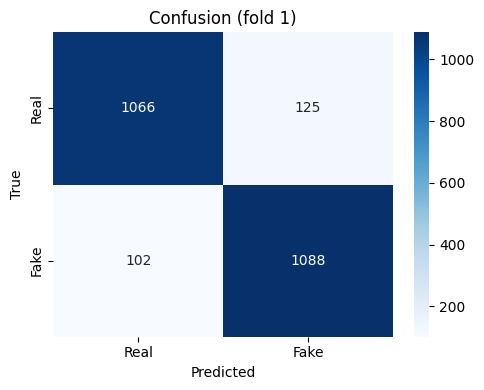

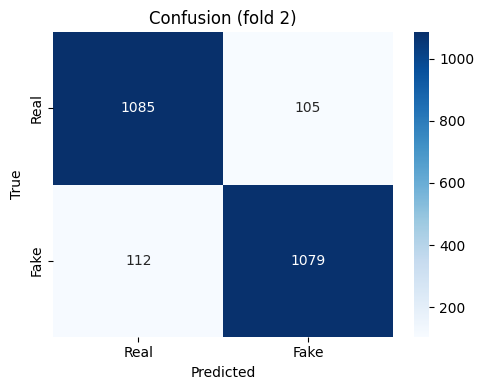

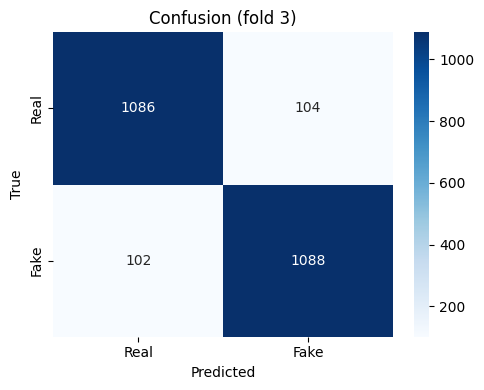

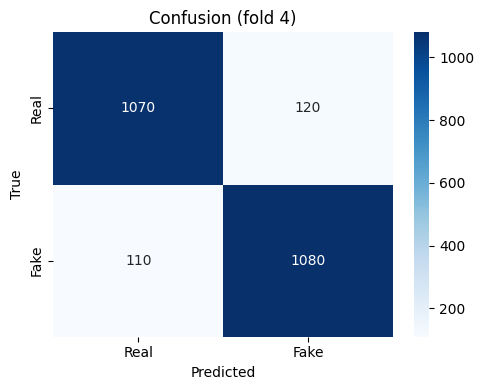

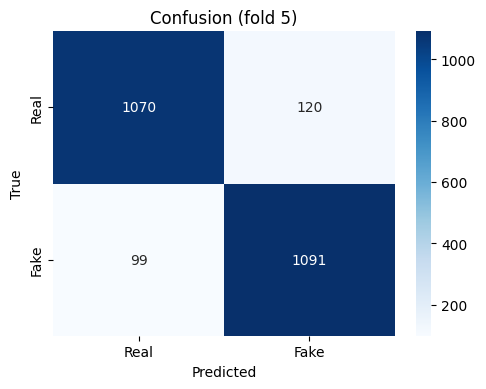


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.904662   0.896950  0.914286  0.905535  0.278402
1     2  0.908862   0.911318  0.905961  0.908632  0.276476
2     3  0.913445   0.912752  0.914286  0.913518  0.263463
3     4  0.903361   0.900000  0.907563  0.903766  0.273254
4     5  0.907983   0.900908  0.916807  0.908788  0.276526

===== MÉDIAS =====
fold         3.000000
accuracy     0.907663
precision    0.904385
recall       0.911781
f1           0.908048
log_loss     0.273624
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.003952
precision    0.007153
recall       0.004729
f1           0.003724
log_loss     0.005974
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=55, max_depth=64, criterion='entropy',bootstrap=False, random_state=42)
result = evaluate_model_cv(model, X, y)

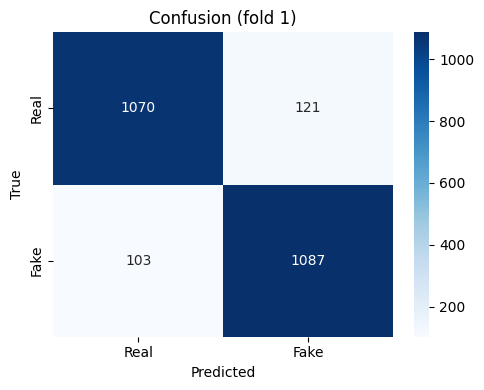

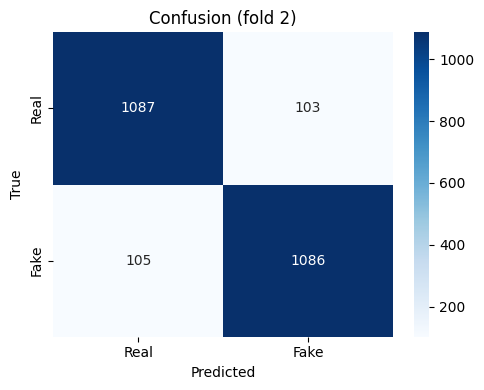

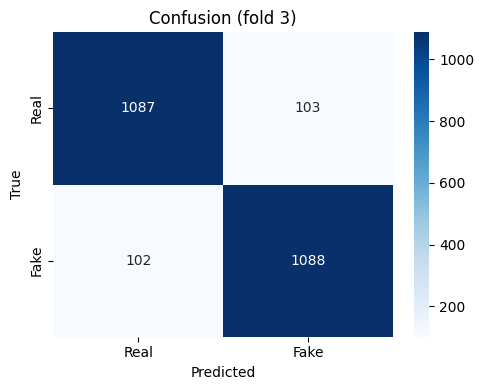

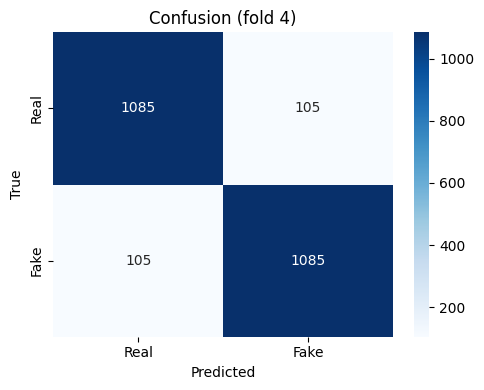

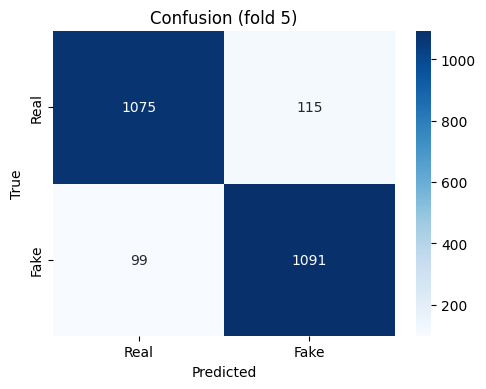


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.905922   0.899834  0.913445  0.906589  0.262521
1     2  0.912642   0.913373  0.911839  0.912605  0.259997
2     3  0.913866   0.913518  0.914286  0.913902  0.250475
3     4  0.911765   0.911765  0.911765  0.911765  0.253169
4     5  0.910084   0.904643  0.916807  0.910684  0.263602

===== MÉDIAS =====
fold         3.000000
accuracy     0.910856
precision    0.908627
recall       0.913628
f1           0.911109
log_loss     0.257953
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.003083
precision    0.006113
recall       0.002076
f1           0.002787
log_loss     0.005826
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=75, max_depth=32, criterion='entropy',bootstrap=False, random_state=42)
result = evaluate_model_cv(model, X, y)

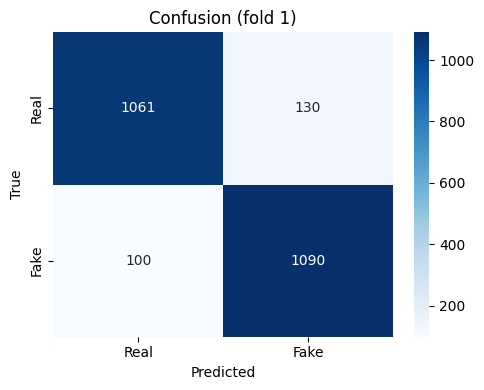

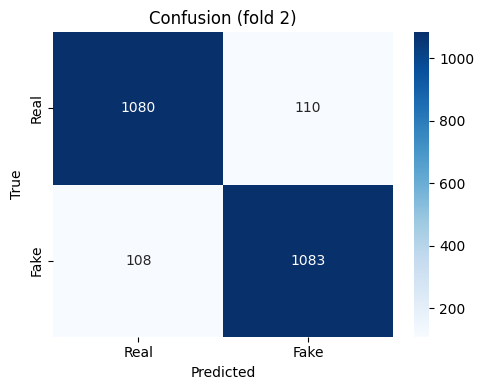

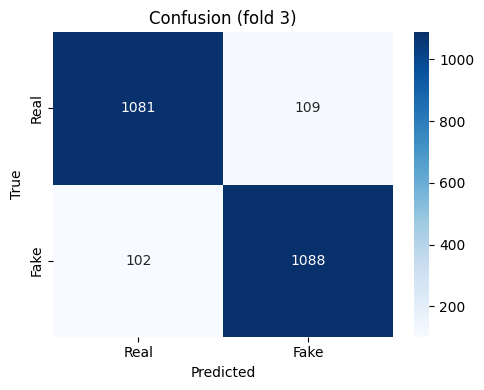

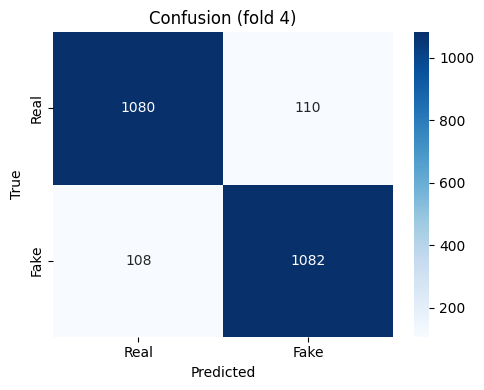

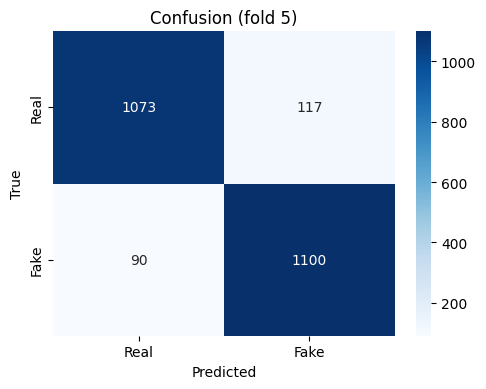


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.903402   0.893443  0.915966  0.904564  0.269702
1     2  0.908442   0.907795  0.909320  0.908557  0.269370
2     3  0.911345   0.908939  0.914286  0.911605  0.254069
3     4  0.908403   0.907718  0.909244  0.908480  0.290139
4     5  0.913025   0.903862  0.924370  0.914001  0.266782

===== MÉDIAS =====
fold         3.000000
accuracy     0.908923
precision    0.904351
recall       0.914637
f1           0.909441
log_loss     0.270013
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.003663
precision    0.006393
recall       0.006204
f1           0.003569
log_loss     0.012944
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=75, criterion='entropy', random_state=42)
result = evaluate_model_cv(model, X, y)

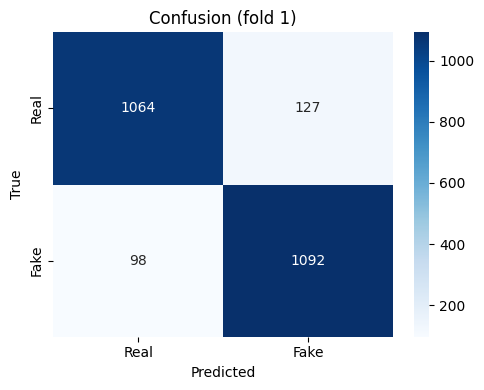

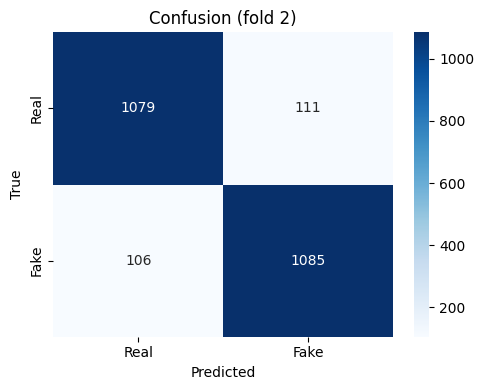

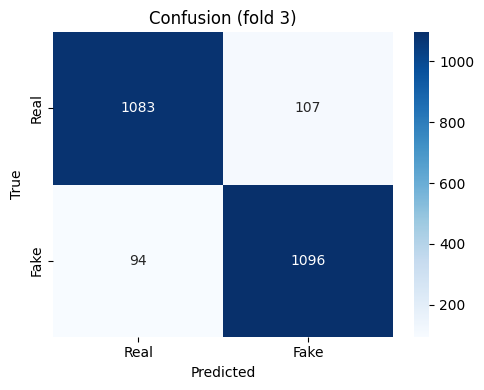

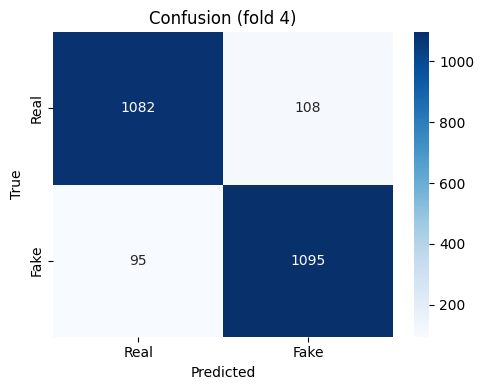

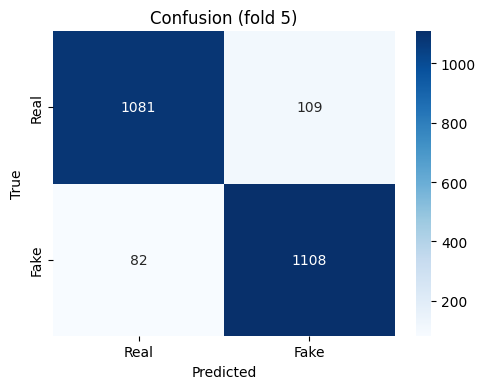


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.905502   0.895816  0.917647  0.906600  0.285257
1     2  0.908862   0.907191  0.910999  0.909091  0.283578
2     3  0.915546   0.911056  0.921008  0.916005  0.271939
3     4  0.914706   0.910224  0.920168  0.915169  0.293956
4     5  0.919748   0.910435  0.931092  0.920648  0.280638

===== MÉDIAS =====
fold         3.000000
accuracy     0.912873
precision    0.906945
recall       0.920183
f1           0.913503
log_loss     0.283073
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005661
precision    0.006398
recall       0.007254
f1           0.005639
log_loss     0.007958
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_features="log2", n_estimators=75, criterion='entropy', random_state=42)
result = evaluate_model_cv(model, X, y)

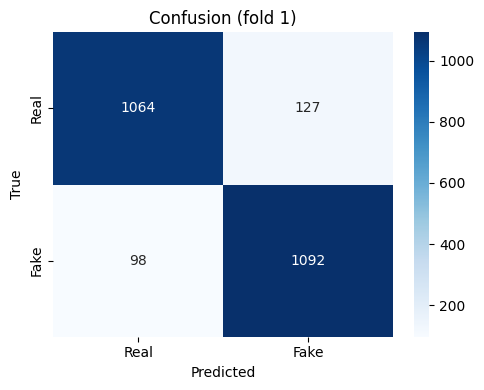

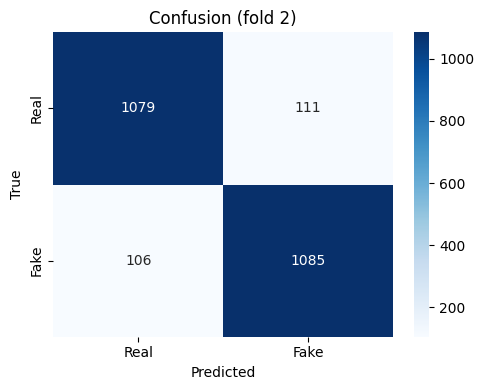

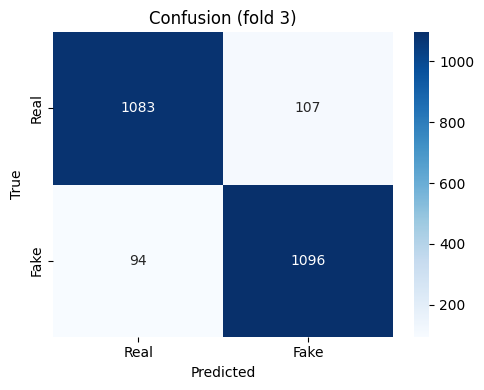

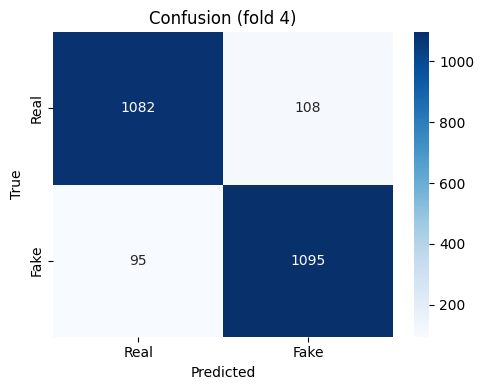

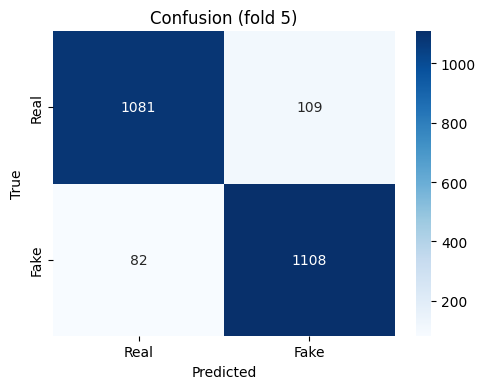


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.905502   0.895816  0.917647  0.906600  0.285257
1     2  0.908862   0.907191  0.910999  0.909091  0.283578
2     3  0.915546   0.911056  0.921008  0.916005  0.271939
3     4  0.914706   0.910224  0.920168  0.915169  0.293956
4     5  0.919748   0.910435  0.931092  0.920648  0.280638

===== MÉDIAS =====
fold         3.000000
accuracy     0.912873
precision    0.906945
recall       0.920183
f1           0.913503
log_loss     0.283073
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005661
precision    0.006398
recall       0.007254
f1           0.005639
log_loss     0.007958
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_features="log2", n_estimators=75, max_depth=128, criterion='entropy', random_state=42)
result = evaluate_model_cv(model, X, y)

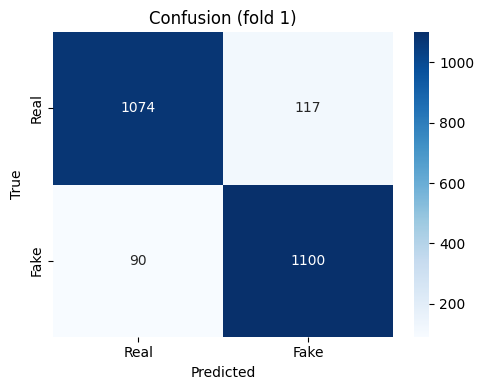

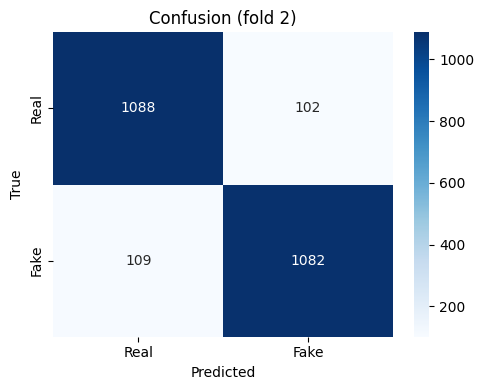

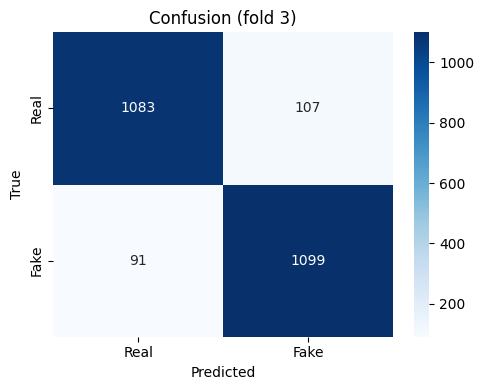

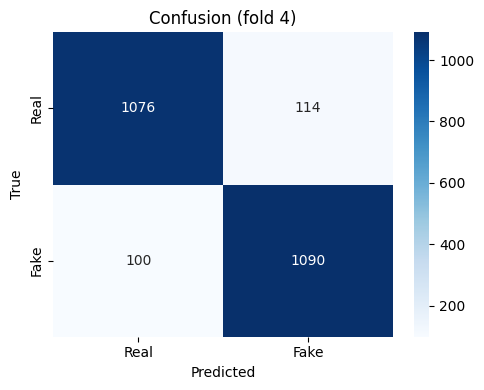

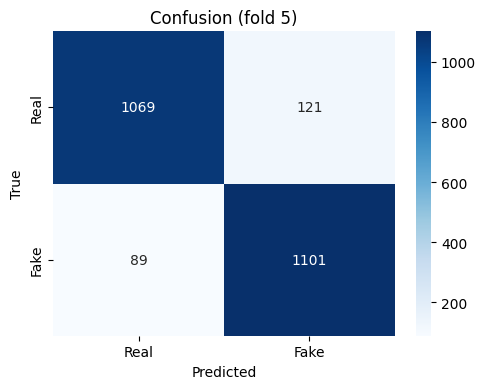


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.913062   0.903862  0.924370  0.914001  0.282861
1     2  0.911382   0.913851  0.908480  0.911158  0.283237
2     3  0.916807   0.911277  0.923529  0.917362  0.272393
3     4  0.910084   0.905316  0.915966  0.910610  0.280847
4     5  0.911765   0.900982  0.925210  0.912935  0.285209

===== MÉDIAS =====
fold         3.000000
accuracy     0.912620
precision    0.907058
recall       0.919511
f1           0.913213
log_loss     0.280909
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.002570
precision    0.005341
recall       0.007185
f1           0.002689
log_loss     0.005006
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_features="log2", n_estimators=75, max_depth=50, criterion='entropy', random_state=42)
result = evaluate_model_cv(model, X, y)

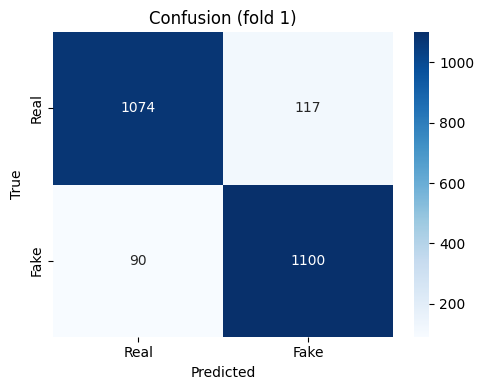

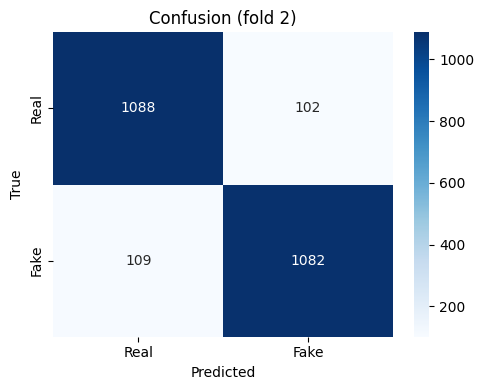

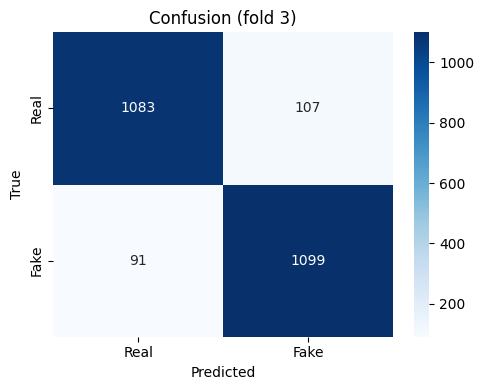

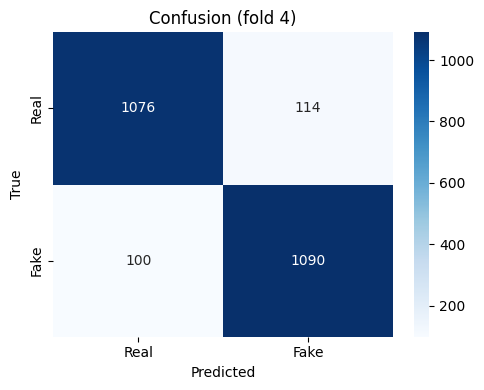

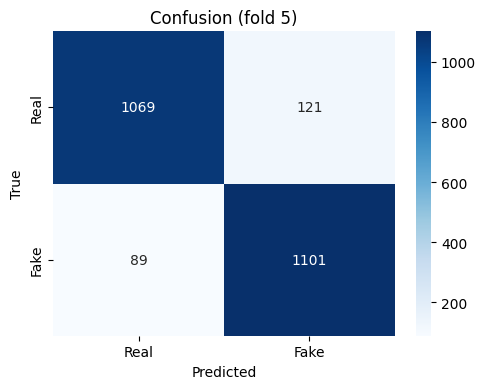


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.913062   0.903862  0.924370  0.914001  0.282861
1     2  0.911382   0.913851  0.908480  0.911158  0.283237
2     3  0.916807   0.911277  0.923529  0.917362  0.272393
3     4  0.910084   0.905316  0.915966  0.910610  0.280847
4     5  0.911765   0.900982  0.925210  0.912935  0.285209

===== MÉDIAS =====
fold         3.000000
accuracy     0.912620
precision    0.907058
recall       0.919511
f1           0.913213
log_loss     0.280909
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.002570
precision    0.005341
recall       0.007185
f1           0.002689
log_loss     0.005006
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_features="log2", n_estimators=75, max_depth=50, criterion='log_loss', random_state=42)
result = evaluate_model_cv(model, X, y)

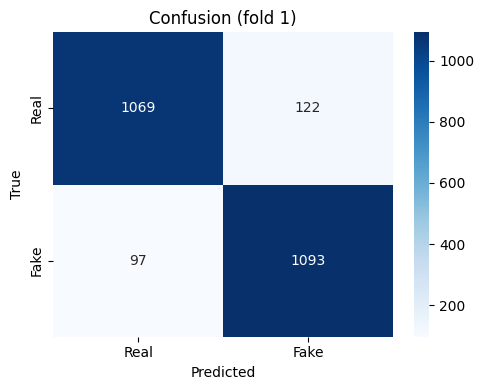

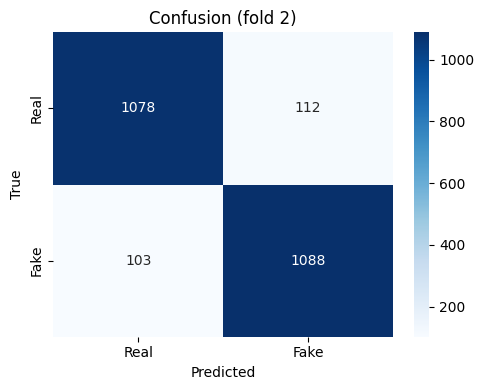

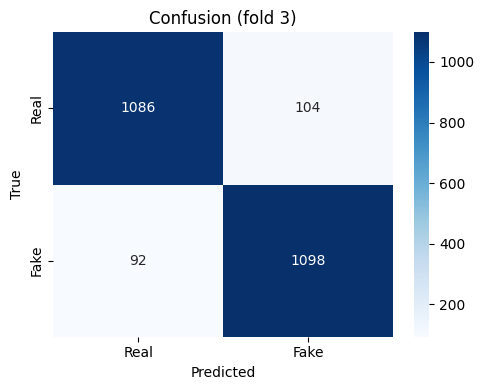

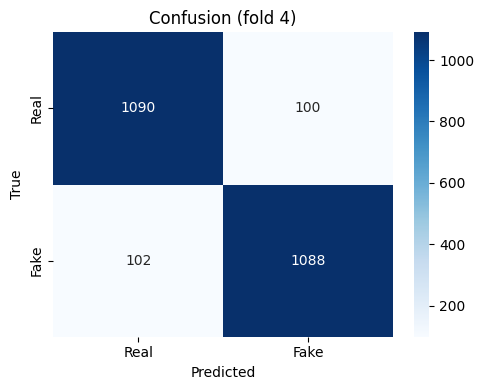

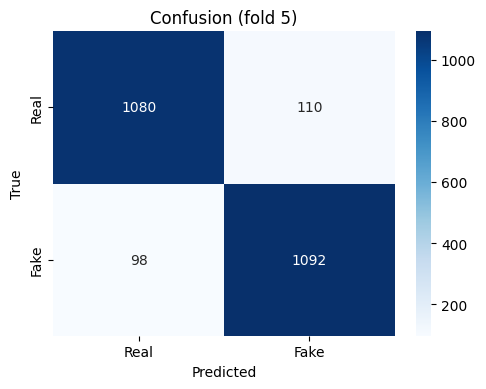


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.908022   0.899588  0.918487  0.908940  0.290743
1     2  0.909702   0.906667  0.913518  0.910079  0.290300
2     3  0.917647   0.913478  0.922689  0.918060  0.279676
3     4  0.915126   0.915825  0.914286  0.915055  0.286035
4     5  0.912605   0.908486  0.917647  0.913043  0.287100

===== MÉDIAS =====
fold         3.000000
accuracy     0.912620
precision    0.908809
recall       0.917325
f1           0.913036
log_loss     0.286771
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.003912
precision    0.006339
recall       0.003673
f1           0.003703
log_loss     0.004450
dtype: float64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(max_features="log2", n_estimators=200, max_depth=50, random_state=42)
result = evaluate_model_cv(model, X, y)

### Support Vector Machines

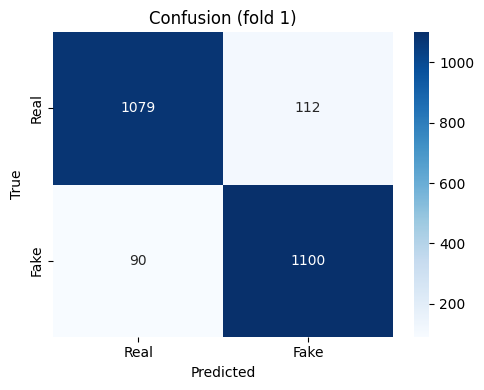

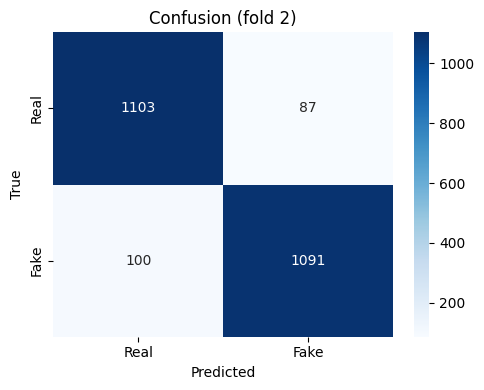

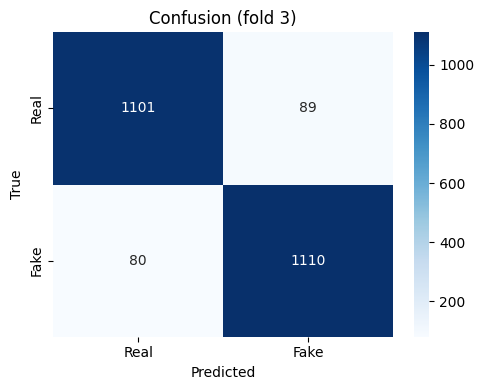

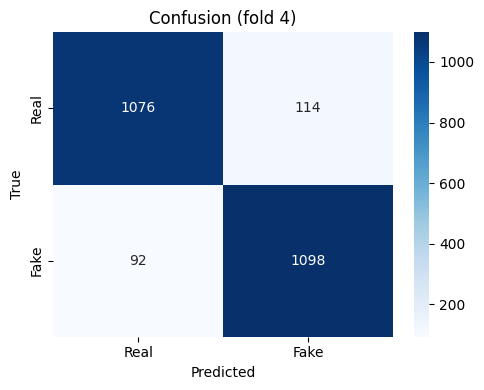

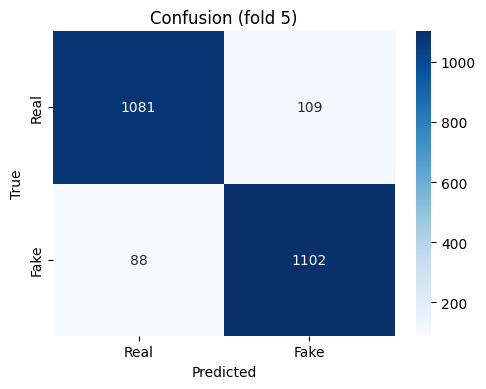


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.915162   0.907591  0.924370  0.915903  0.234981
1     2  0.921462   0.926146  0.916037  0.921064  0.227525
2     3  0.928992   0.925771  0.932773  0.929259  0.217376
3     4  0.913445   0.905941  0.922689  0.914238  0.238086
4     5  0.917227   0.909992  0.926050  0.917951  0.235376

===== MÉDIAS =====
fold         3.000000
accuracy     0.919257
precision    0.915088
recall       0.924384
f1           0.919683
log_loss     0.230669
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006211
precision    0.010028
recall       0.006035
f1           0.005927
log_loss     0.008402
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC()

result = evaluate_model_cv(model, X, y)

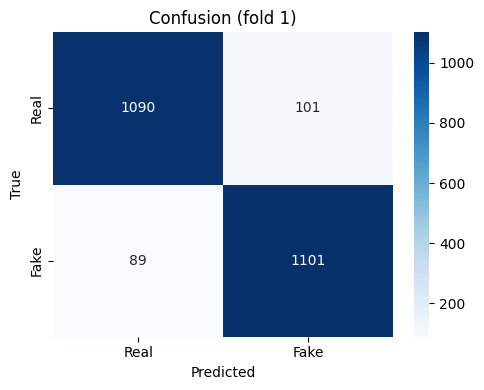

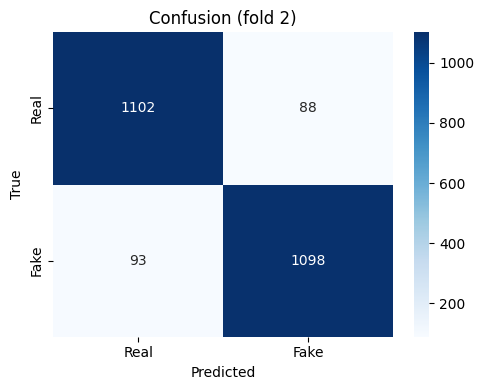

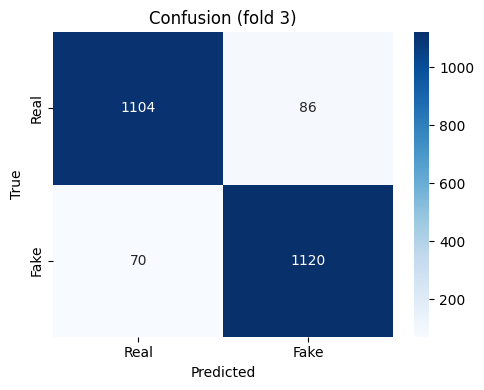

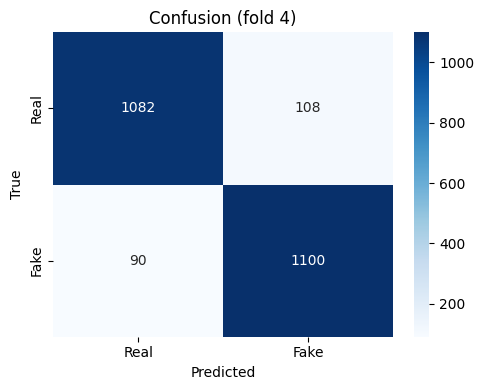

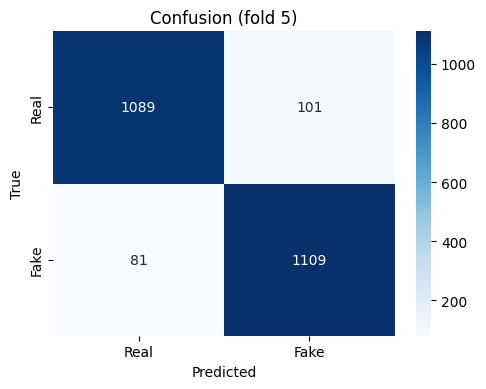


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.920202   0.915973  0.925210  0.920569  0.235243
1     2  0.923982   0.925801  0.921914  0.923854  0.233349
2     3  0.934454   0.928690  0.941176  0.934891  0.221115
3     4  0.916807   0.910596  0.924370  0.917431  0.241177
4     5  0.923529   0.916529  0.931933  0.924167  0.240002

===== MÉDIAS =====
fold         3.000000
accuracy     0.923795
precision    0.919518
recall       0.928921
f1           0.924182
log_loss     0.234177
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006623
precision    0.007495
recall       0.007792
f1           0.006585
log_loss     0.007990
dtype: float64


In [ ]:
from sklearn import svm
# melhor svm
model = svm.SVC(C=5)

result = evaluate_model_cv(model, X, y)

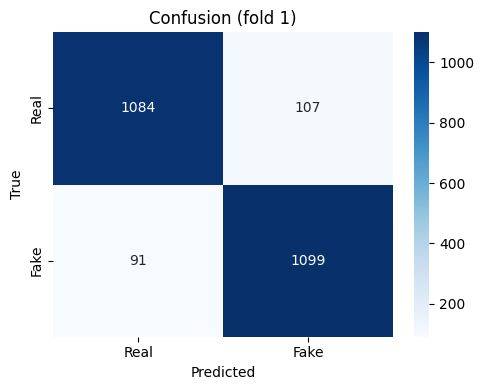

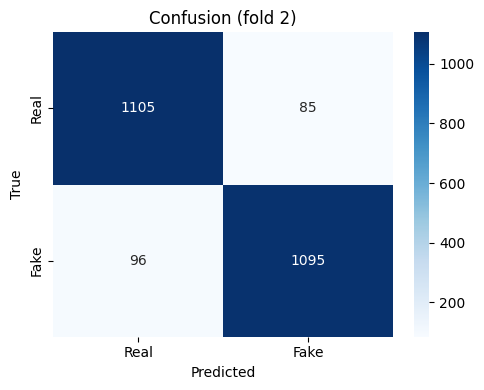

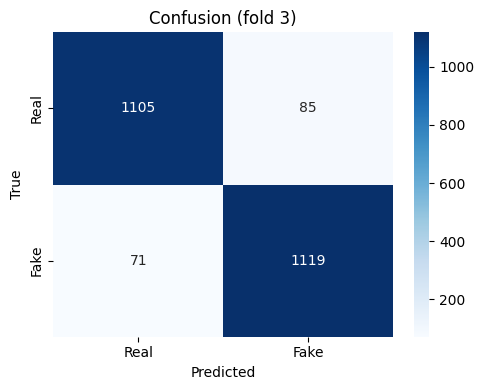

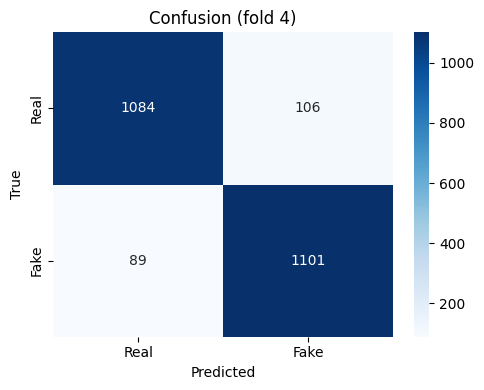

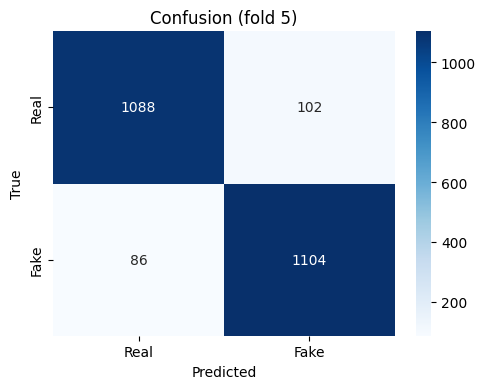


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.916842   0.911277  0.923529  0.917362  0.230518
1     2  0.923982   0.927966  0.919395  0.923661  0.225957
2     3  0.934454   0.929402  0.940336  0.934837  0.215362
3     4  0.918067   0.912179  0.925210  0.918648  0.234153
4     5  0.921008   0.915423  0.927731  0.921536  0.233629

===== MÉDIAS =====
fold         3.000000
accuracy     0.922871
precision    0.919249
recall       0.927240
f1           0.923209
log_loss     0.227924
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.007041
precision    0.008764
recall       0.007924
f1           0.006950
log_loss     0.007742
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=2)

result = evaluate_model_cv(model, X, y)

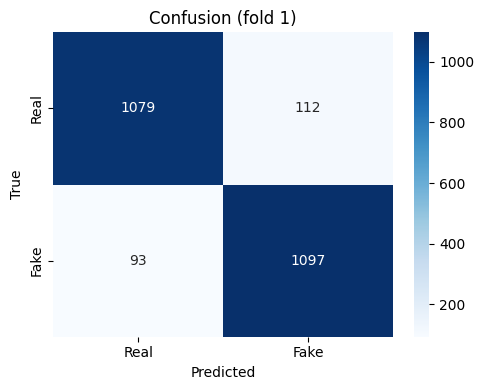

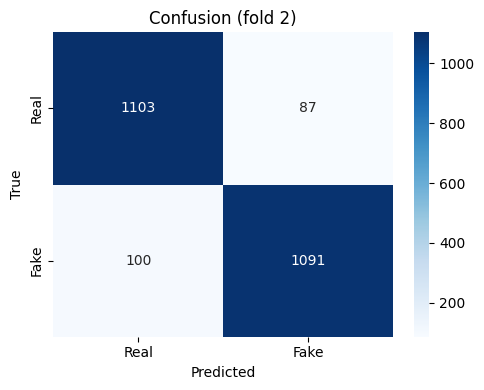

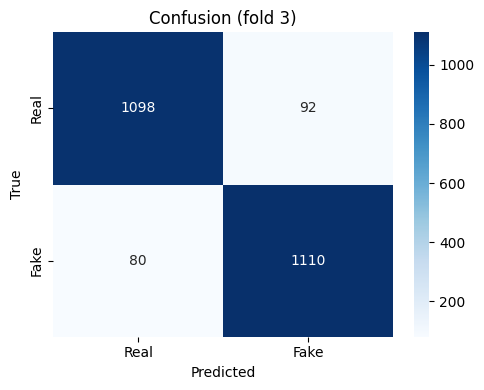

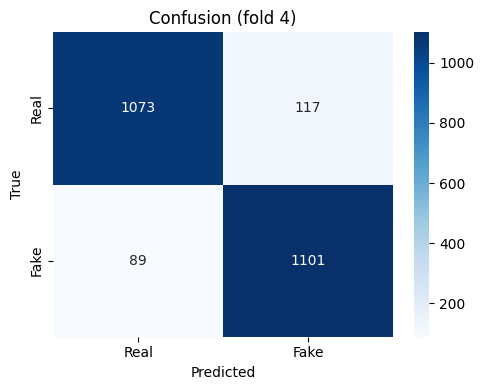

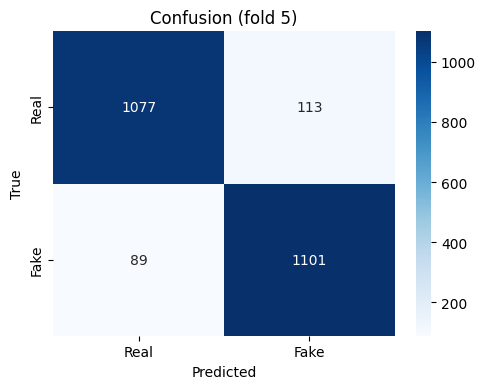


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.913902   0.907361  0.921849  0.914548  0.236634
1     2  0.921462   0.926146  0.916037  0.921064  0.228854
2     3  0.927731   0.923461  0.932773  0.928094  0.218607
3     4  0.913445   0.903941  0.925210  0.914452  0.239514
4     5  0.915126   0.906919  0.925210  0.915973  0.236673

===== MÉDIAS =====
fold         3.000000
accuracy     0.918333
precision    0.913566
recall       0.924216
f1           0.918826
log_loss     0.232056
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006163
precision    0.010386
recall       0.006077
f1           0.005841
log_loss     0.008500
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.9)

result = evaluate_model_cv(model, X, y)

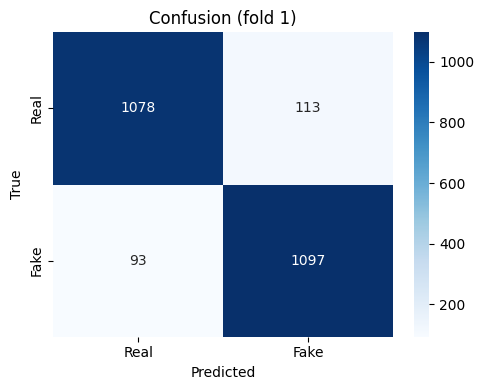

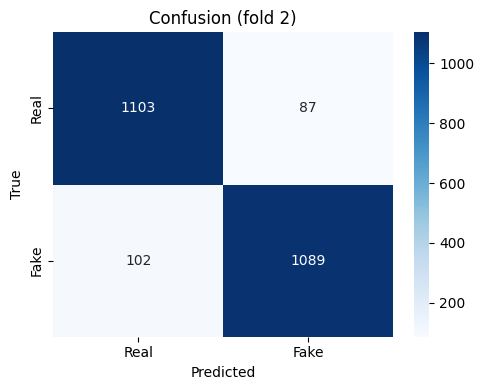

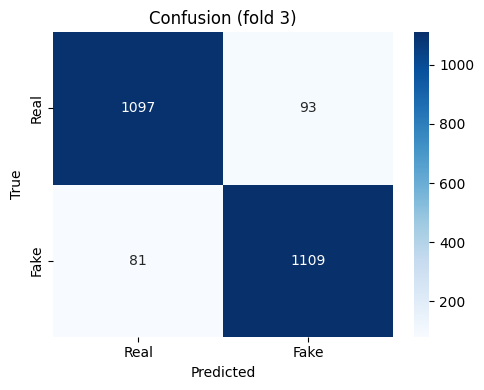

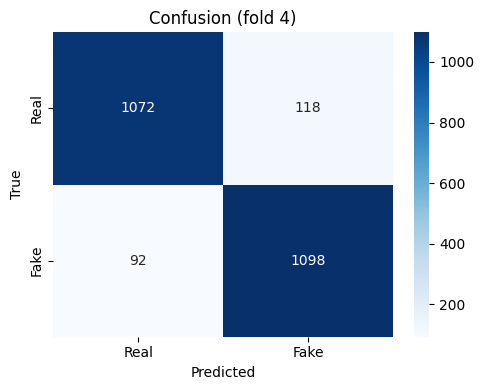

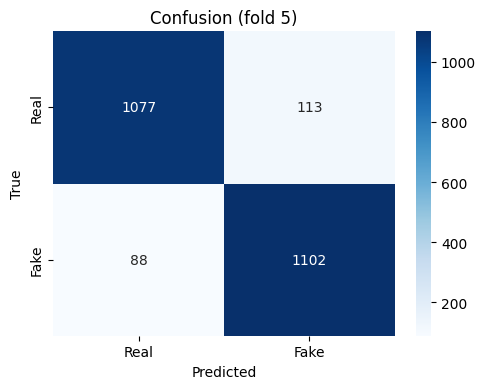


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.913482   0.906612  0.921849  0.914167  0.237633
1     2  0.920622   0.926020  0.914358  0.920152  0.229643
2     3  0.926891   0.922629  0.931933  0.927258  0.219393
3     4  0.911765   0.902961  0.922689  0.912718  0.240288
4     5  0.915546   0.906996  0.926050  0.916424  0.237508

===== MÉDIAS =====
fold         3.000000
accuracy     0.917661
precision    0.913043
recall       0.923376
f1           0.918144
log_loss     0.232893
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006137
precision    0.010487
recall       0.006413
f1           0.005816
log_loss     0.008533
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.85)

result = evaluate_model_cv(model, X, y)

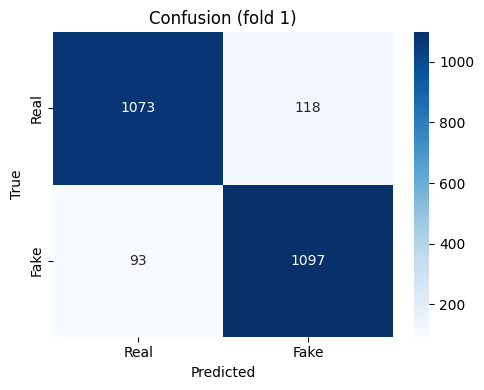

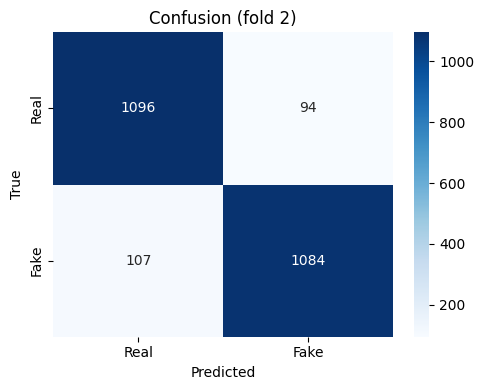

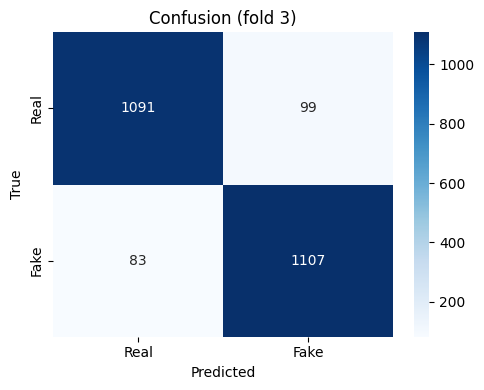

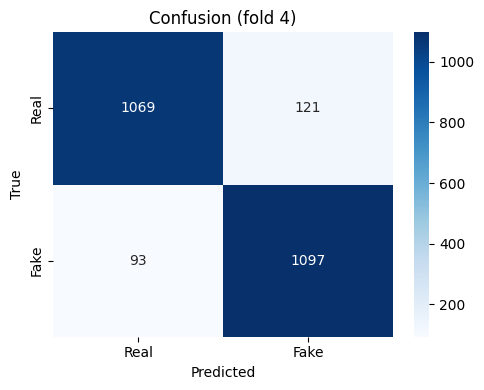

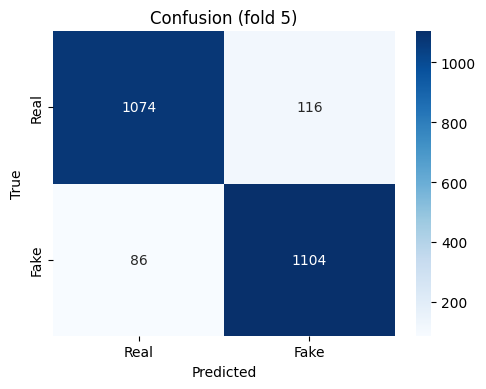


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.911382   0.902881  0.921849  0.912266  0.241231
1     2  0.915582   0.920204  0.910160  0.915154  0.232584
2     3  0.923529   0.917910  0.930252  0.924040  0.222700
3     4  0.910084   0.900657  0.921849  0.911130  0.243182
4     5  0.915126   0.904918  0.927731  0.916183  0.240691

===== MÉDIAS =====
fold         3.000000
accuracy     0.915141
precision    0.909314
recall       0.922368
f1           0.915754
log_loss     0.236078
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.005250
precision    0.009057
recall       0.007754
f1           0.005068
log_loss     0.008507
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.7)

result = evaluate_model_cv(model, X, y)

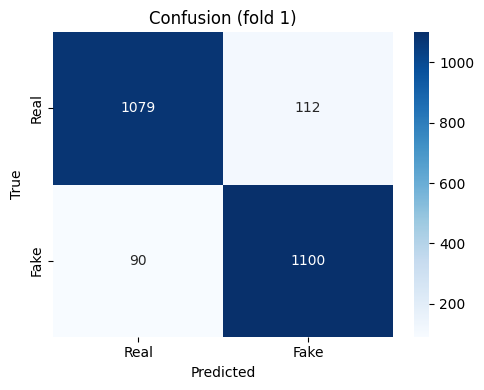

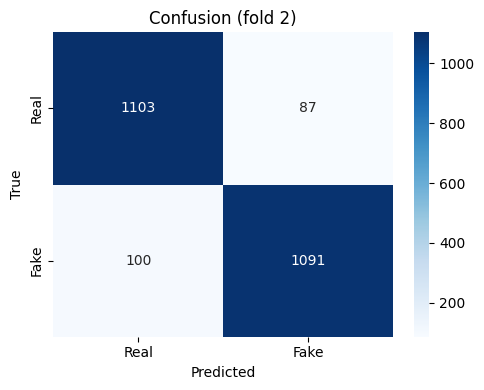

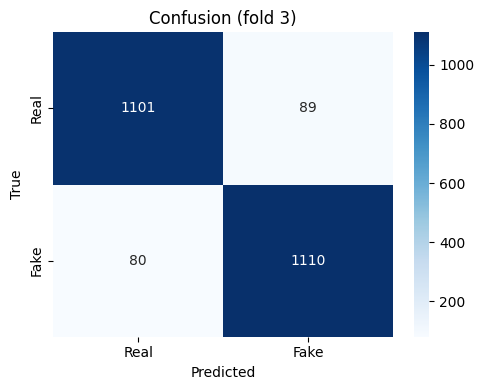

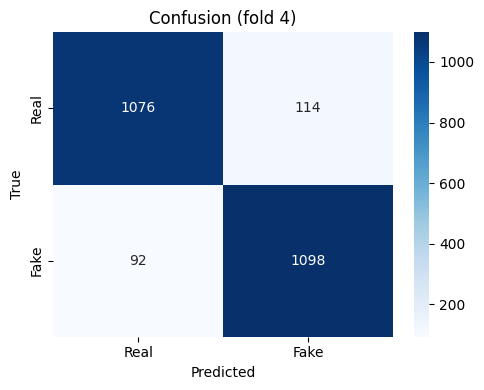

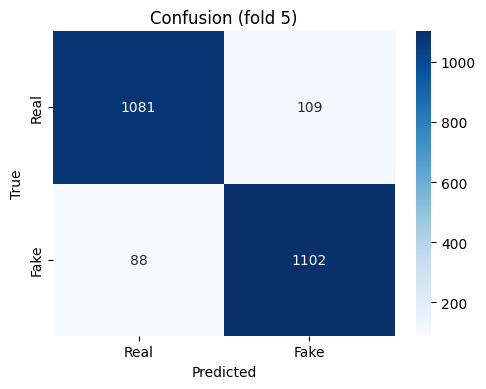


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.915162   0.907591  0.924370  0.915903  0.234981
1     2  0.921462   0.926146  0.916037  0.921064  0.227525
2     3  0.928992   0.925771  0.932773  0.929259  0.217376
3     4  0.913445   0.905941  0.922689  0.914238  0.238086
4     5  0.917227   0.909992  0.926050  0.917951  0.235376

===== MÉDIAS =====
fold         3.000000
accuracy     0.919257
precision    0.915088
recall       0.924384
f1           0.919683
log_loss     0.230669
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006211
precision    0.010028
recall       0.006035
f1           0.005927
log_loss     0.008402
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(max_iter=-1)

result = evaluate_model_cv(model, X, y)

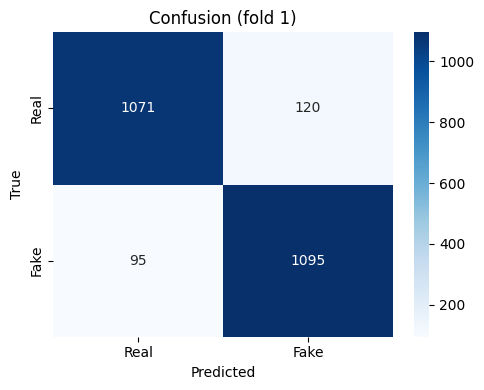

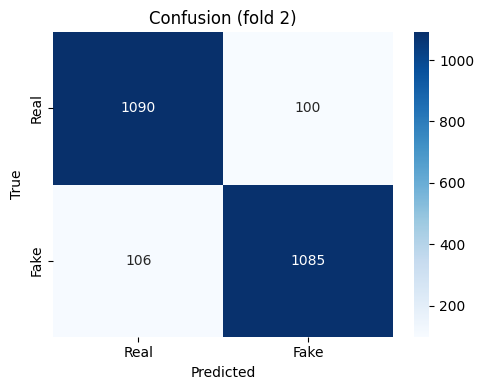

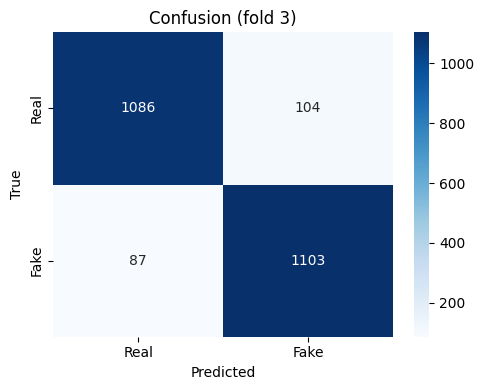

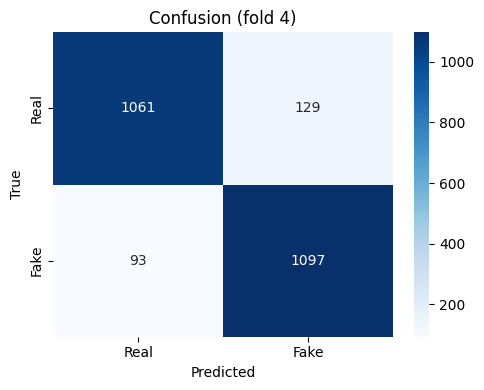

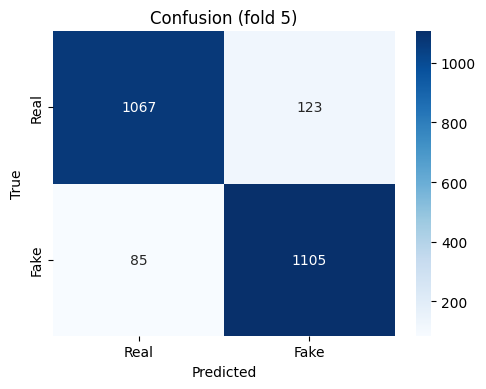


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.909702   0.901235  0.920168  0.910603  0.248405
1     2  0.913482   0.915612  0.910999  0.913300  0.239387
2     3  0.919748   0.913836  0.926891  0.920317  0.230327
3     4  0.906723   0.894780  0.921849  0.908113  0.249218
4     5  0.912605   0.899837  0.928571  0.913978  0.247859

===== MÉDIAS =====
fold         3.000000
accuracy     0.912452
precision    0.905060
recall       0.921696
f1           0.913262
log_loss     0.243039
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.004866
precision    0.009165
recall       0.006911
f1           0.004579
log_loss     0.008142
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.5)

result = evaluate_model_cv(model, X, y)

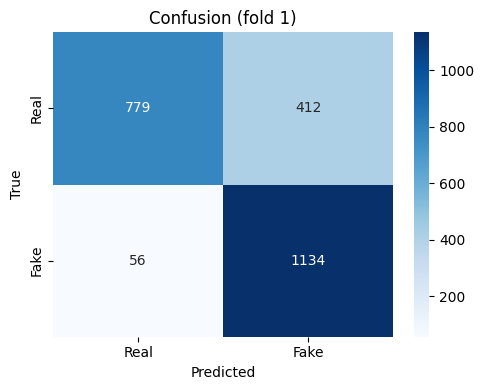

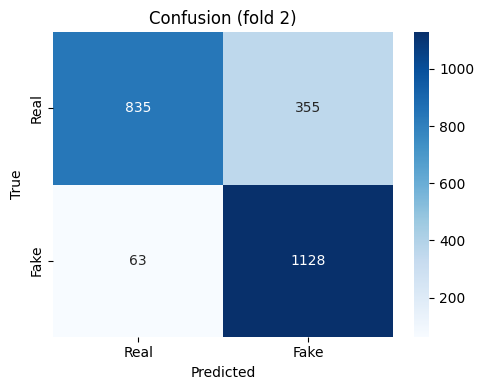

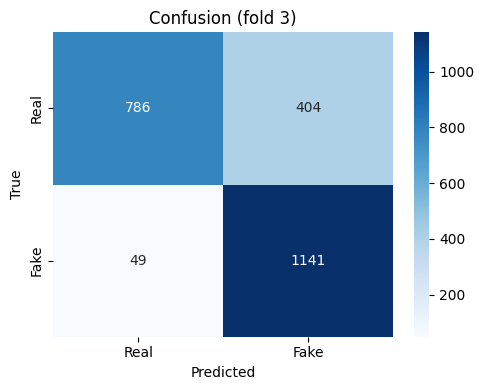

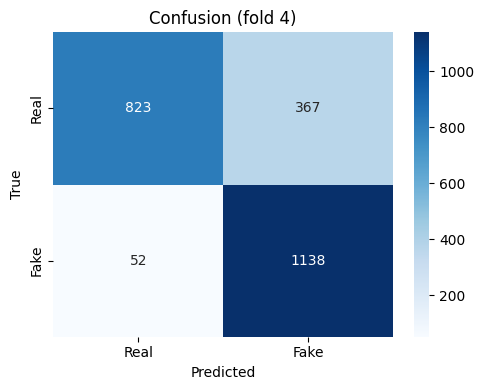

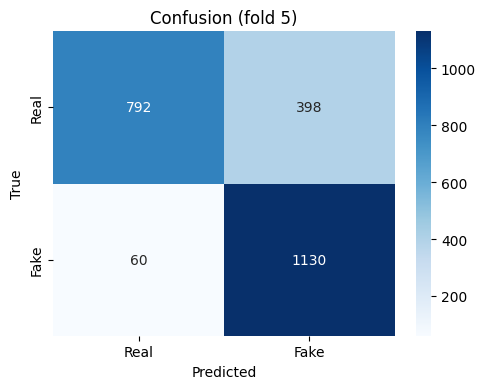


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.803444   0.733506  0.952941  0.828947  0.455124
1     2  0.824444   0.760620  0.947103  0.843680  0.447066
2     3  0.809664   0.738511  0.958824  0.834369  0.445840
3     4  0.823950   0.756146  0.956303  0.844527  0.443003
4     5  0.807563   0.739529  0.949580  0.831494  0.455151

===== MÉDIAS =====
fold         3.000000
accuracy     0.813813
precision    0.745662
recall       0.952950
f1           0.836603
log_loss     0.449237
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.009741
precision    0.011939
recall       0.004777
f1           0.007116
log_loss     0.005585
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='sigmoid', gamma='auto')

result = evaluate_model_cv(model, X, y)

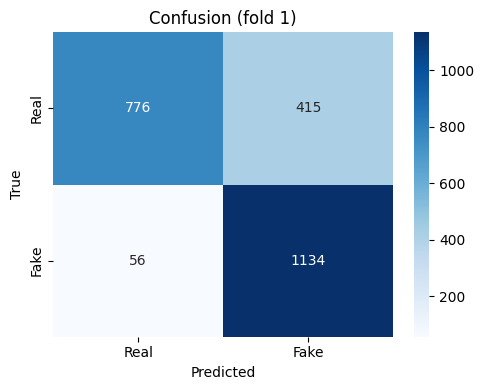

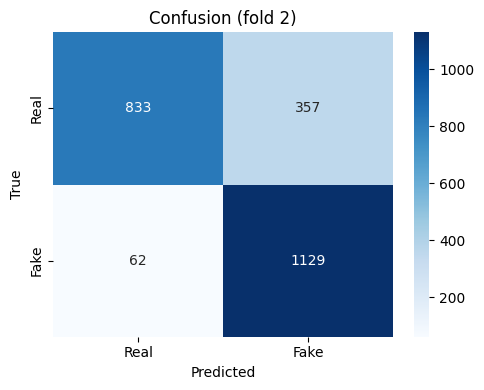

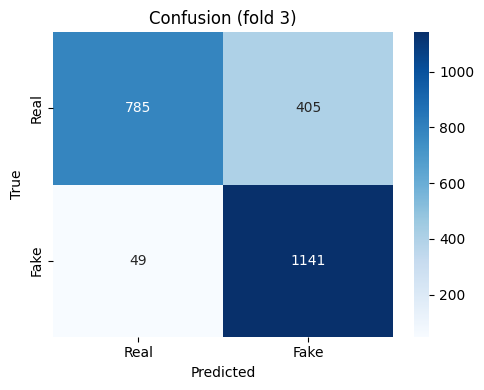

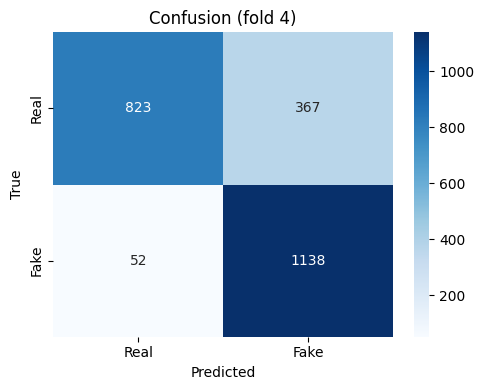

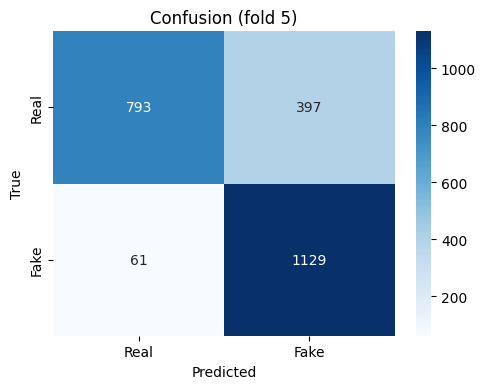


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.802184   0.732085  0.952941  0.828039  0.455889
1     2  0.824024   0.759758  0.947943  0.843482  0.447785
2     3  0.809244   0.738034  0.958824  0.834064  0.446549
3     4  0.823950   0.756146  0.956303  0.844527  0.443558
4     5  0.807563   0.739843  0.948739  0.831370  0.455454

===== MÉDIAS =====
fold         3.000000
accuracy     0.813393
precision    0.745173
recall       0.952950
f1           0.836296
log_loss     0.449847
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.010016
precision    0.012081
recall       0.004705
f1           0.007362
log_loss     0.005537
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.5, gamma='auto')

result = evaluate_model_cv(model, X, y)

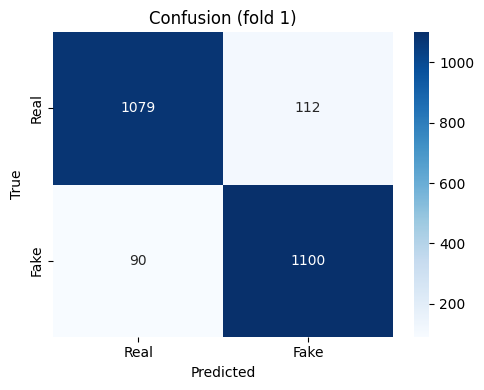

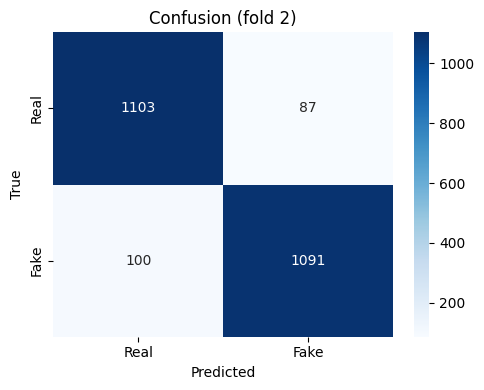

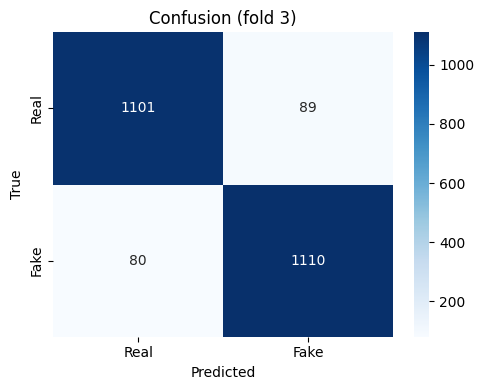

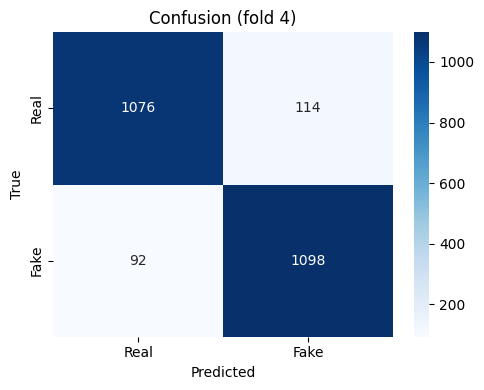

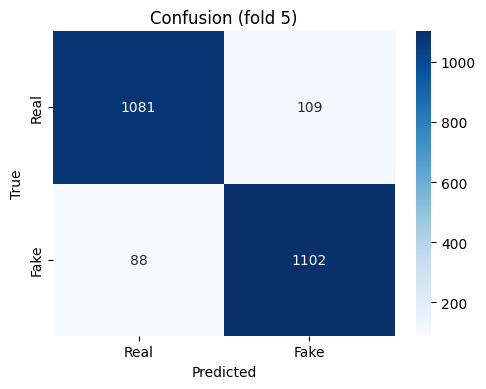


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.915162   0.907591  0.924370  0.915903  0.234981
1     2  0.921462   0.926146  0.916037  0.921064  0.227525
2     3  0.928992   0.925771  0.932773  0.929259  0.217376
3     4  0.913445   0.905941  0.922689  0.914238  0.238086
4     5  0.917227   0.909992  0.926050  0.917951  0.235376

===== MÉDIAS =====
fold         3.000000
accuracy     0.919257
precision    0.915088
recall       0.924384
f1           0.919683
log_loss     0.230669
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006211
precision    0.010028
recall       0.006035
f1           0.005927
log_loss     0.008402
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(shrinking=False)

result = evaluate_model_cv(model, X, y)

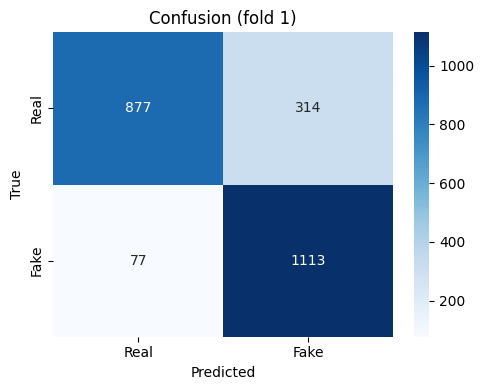

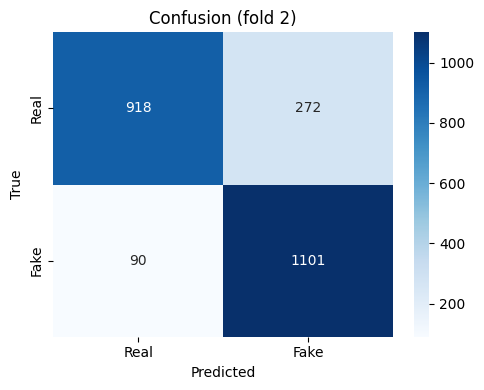

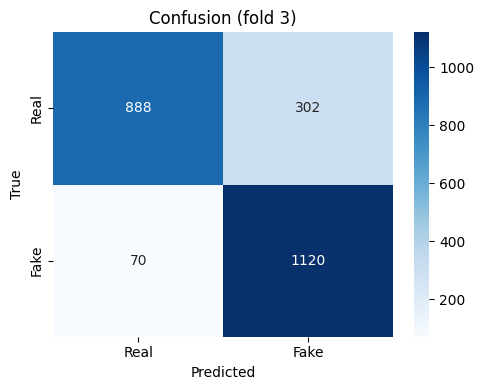

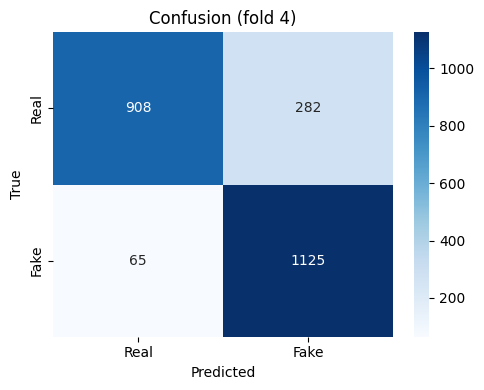

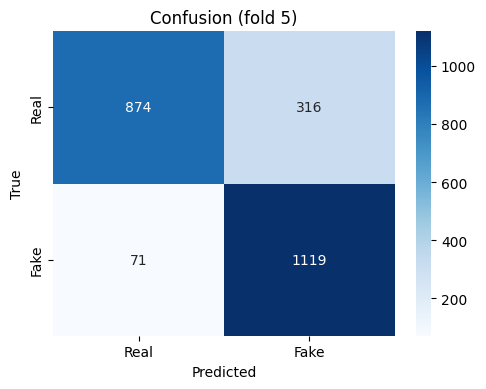


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.835783   0.779958  0.935294  0.850592  0.398180
1     2  0.847963   0.801894  0.924433  0.858814  0.387294
2     3  0.843697   0.787623  0.941176  0.857580  0.385554
3     4  0.854202   0.799574  0.945378  0.866384  0.384143
4     5  0.837395   0.779791  0.940336  0.852571  0.396545

===== MÉDIAS =====
fold         3.000000
accuracy     0.843808
precision    0.789768
recall       0.937324
f1           0.857189
log_loss     0.390343
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.007597
precision    0.010530
recall       0.008048
f1           0.006168
log_loss     0.006530
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(gamma='auto')

result = evaluate_model_cv(model, X, y)

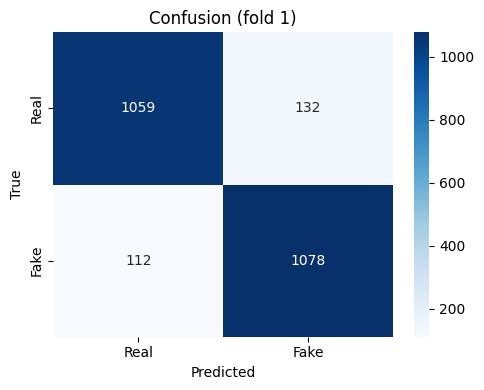

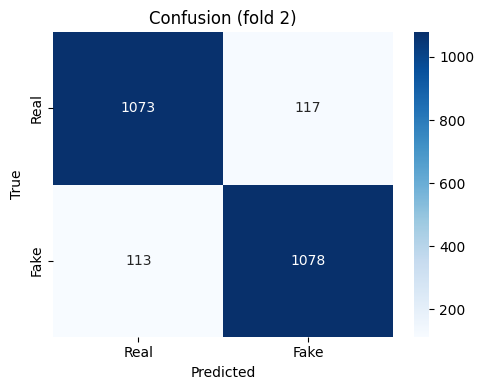

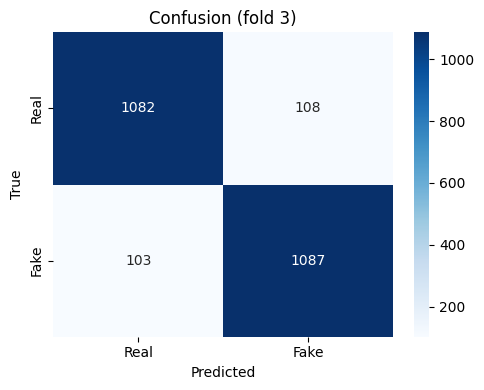

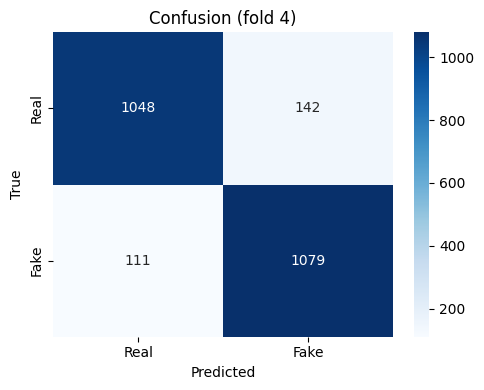

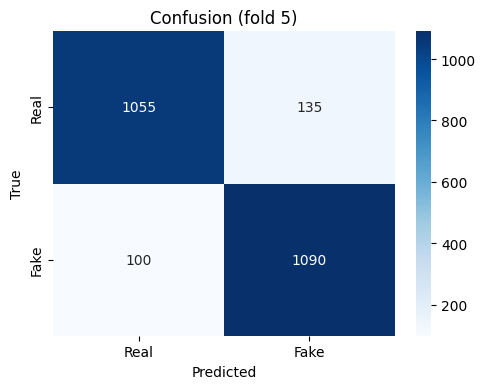


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.897522   0.890909  0.905882  0.898333  0.264434
1     2  0.903402   0.902092  0.905122  0.903604  0.243349
2     3  0.911345   0.909623  0.913445  0.911530  0.231512
3     4  0.893697   0.883702  0.906723  0.895064  0.269207
4     5  0.901261   0.889796  0.915966  0.902692  0.258341

===== MÉDIAS =====
fold         3.000000
accuracy     0.901445
precision    0.895224
recall       0.909428
f1           0.902245
log_loss     0.253369
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006657
precision    0.010433
recall       0.004933
f1           0.006228
log_loss     0.015621
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='linear', gamma='auto')

result = evaluate_model_cv(model, X, y)

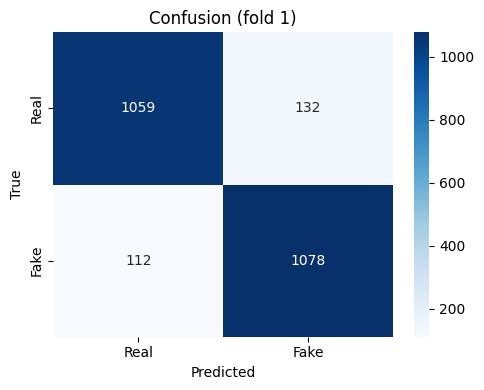

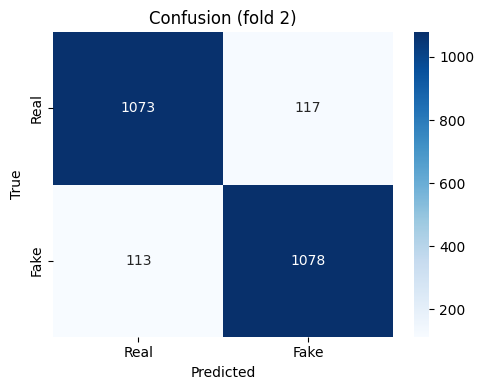

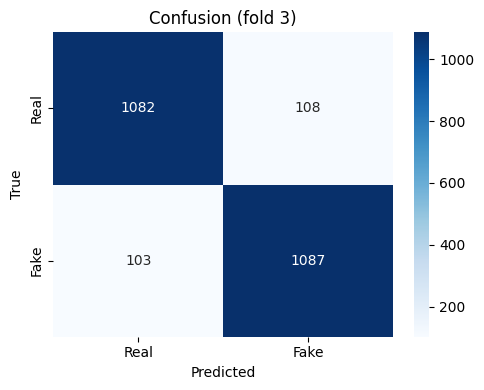

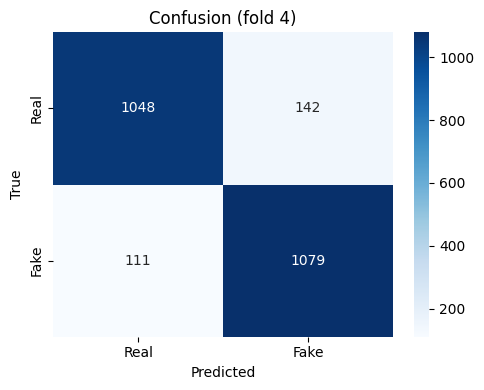

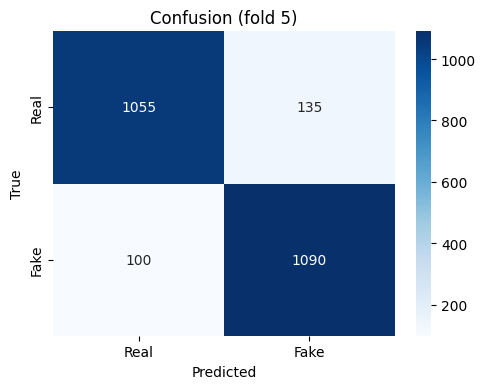


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.897522   0.890909  0.905882  0.898333  0.264434
1     2  0.903402   0.902092  0.905122  0.903604  0.243349
2     3  0.911345   0.909623  0.913445  0.911530  0.231512
3     4  0.893697   0.883702  0.906723  0.895064  0.269207
4     5  0.901261   0.889796  0.915966  0.902692  0.258341

===== MÉDIAS =====
fold         3.000000
accuracy     0.901445
precision    0.895224
recall       0.909428
f1           0.902245
log_loss     0.253369
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006657
precision    0.010433
recall       0.004933
f1           0.006228
log_loss     0.015621
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='linear')

result = evaluate_model_cv(model, X, y)

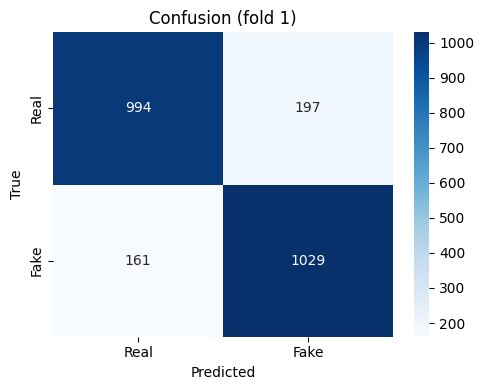

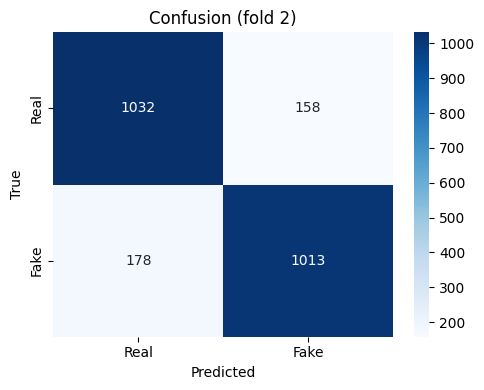

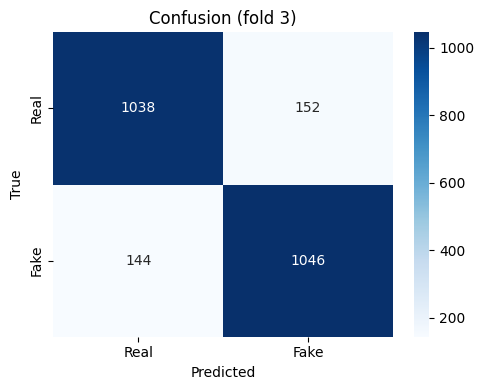

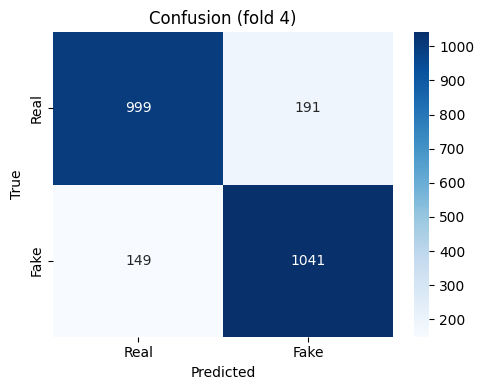

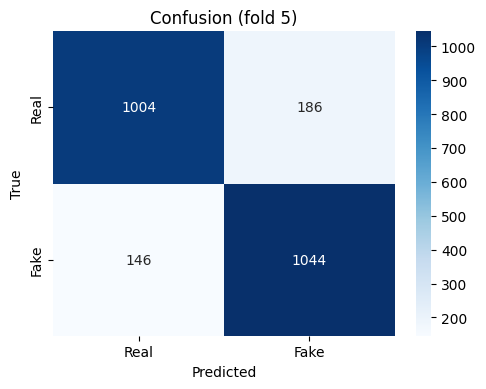


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.849643   0.839315  0.864706  0.851821  0.502642
1     2  0.858883   0.865073  0.850546  0.857748  0.477240
2     3  0.875630   0.873122  0.878992  0.876047  0.425537
3     4  0.857143   0.844968  0.874790  0.859620  0.506060
4     5  0.860504   0.848780  0.877311  0.862810  0.460142

===== MÉDIAS =====
fold         3.000000
accuracy     0.860361
precision    0.854251
recall       0.869269
f1           0.861609
log_loss     0.474324
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.009495
precision    0.014251
recall       0.011843
f1           0.009008
log_loss     0.033162
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='sigmoid')

result = evaluate_model_cv(model, X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


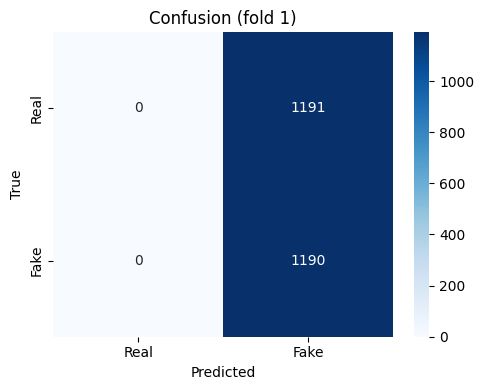

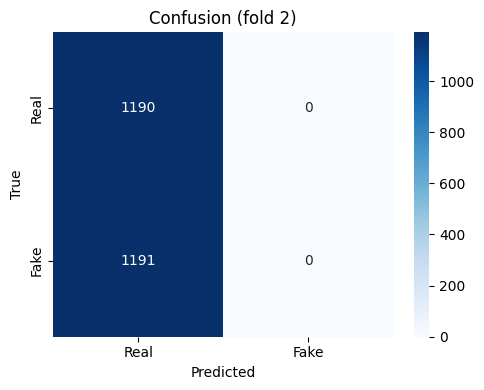

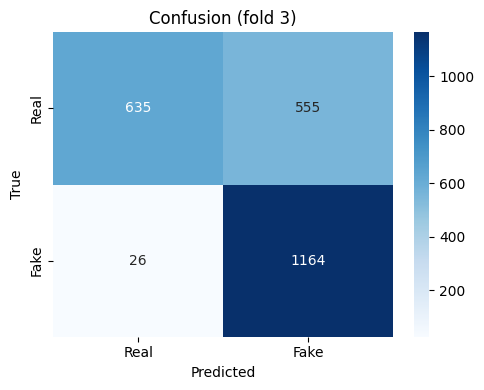

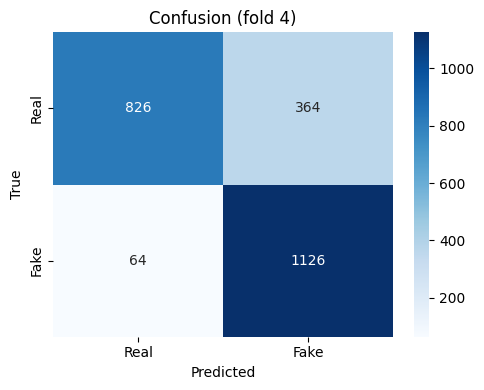

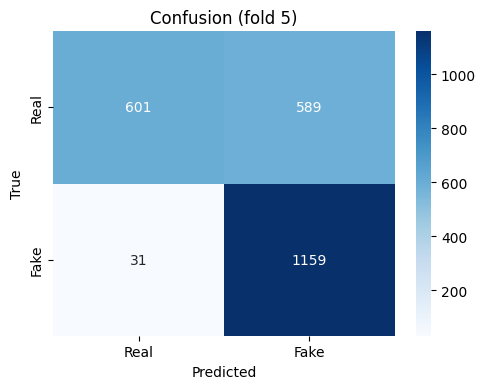


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.499790   0.499790  1.000000  0.666480  1.127345
1     2  0.499790   0.000000  0.000000  0.000000  1.127344
2     3  0.755882   0.677138  0.978151  0.800275  0.693147
3     4  0.820168   0.755705  0.946218  0.840299  0.693147
4     5  0.739496   0.663043  0.973950  0.788972  0.693147

===== MÉDIAS =====
fold         3.000000
accuracy     0.663025
precision    0.519135
recall       0.779664
f1           0.619205
log_loss     0.866826
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.152033
precision    0.304760
recall       0.436265
f1           0.352186
log_loss     0.237820
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(gamma='auto', kernel='poly')

result = evaluate_model_cv(model, X, y)

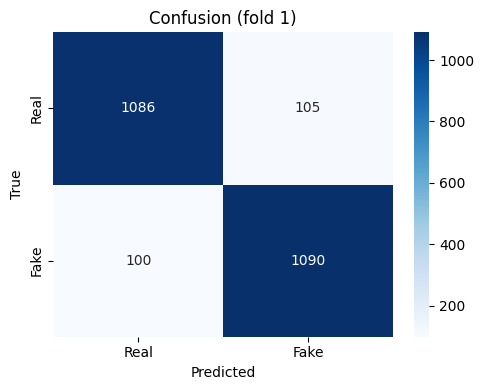

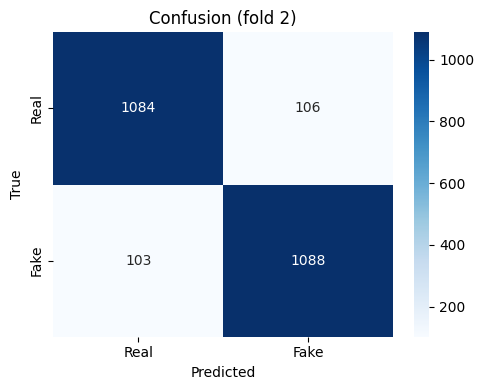

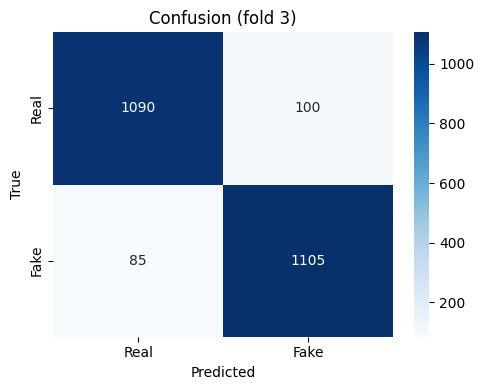

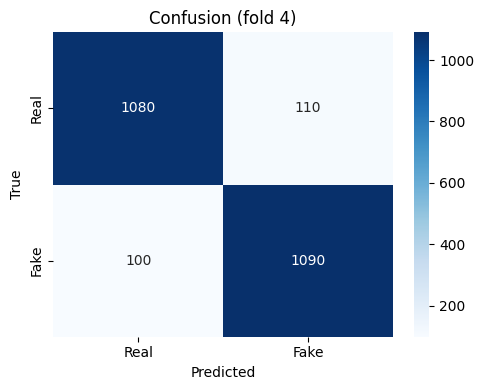

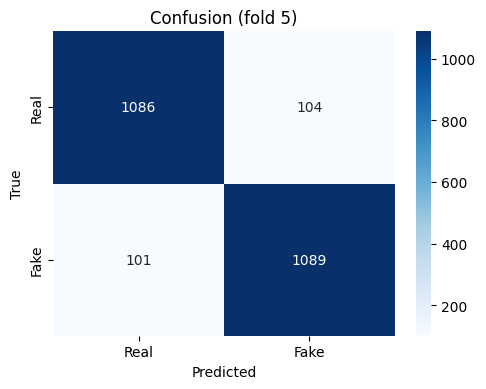


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.913902   0.912134  0.915966  0.914046  0.288114
1     2  0.912222   0.911223  0.913518  0.912369  0.288376
2     3  0.922269   0.917012  0.928571  0.922756  0.279604
3     4  0.911765   0.908333  0.915966  0.912134  0.291254
4     5  0.913866   0.912825  0.915126  0.913974  0.292330

===== MÉDIAS =====
fold         3.000000
accuracy     0.914805
precision    0.912305
recall       0.917830
f1           0.915056
log_loss     0.287936
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.004281
precision    0.003139
recall       0.006087
f1           0.004394
log_loss     0.004999
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='poly')

result = evaluate_model_cv(model, X, y)

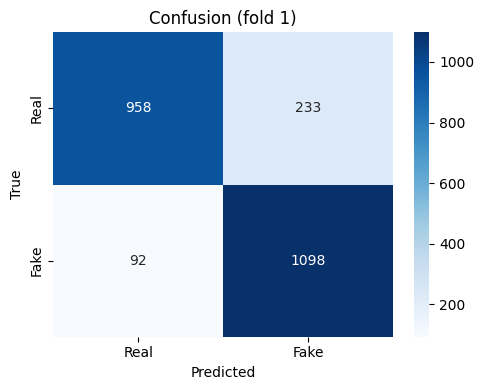

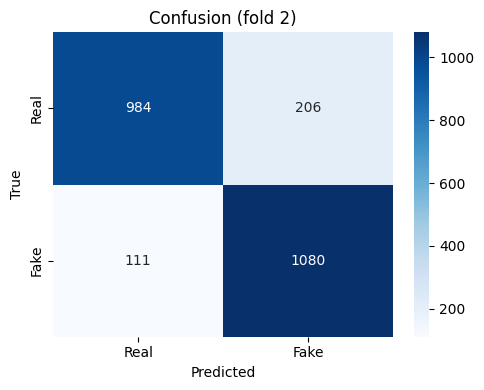

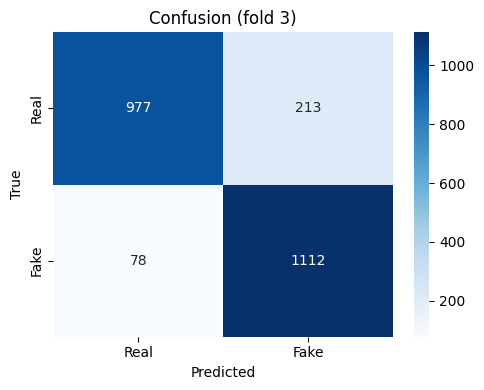

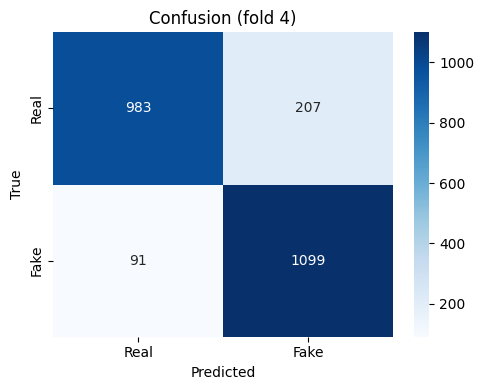

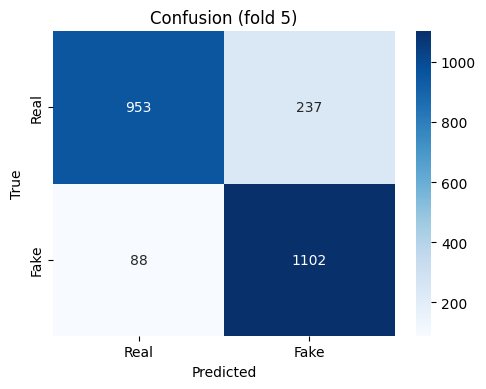


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.863503   0.824944  0.922689  0.871083  0.340144
1     2  0.866863   0.839813  0.906801  0.872023  0.330301
2     3  0.877731   0.839245  0.934454  0.884294  0.323606
3     4  0.874790   0.841501  0.923529  0.880609  0.328019
4     5  0.863445   0.823002  0.926050  0.871491  0.338995

===== MÉDIAS =====
fold         3.000000
accuracy     0.869266
precision    0.833701
recall       0.922705
f1           0.875900
log_loss     0.332213
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.006615
precision    0.008946
recall       0.010035
f1           0.006130
log_loss     0.007145
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(gamma='auto', kernel='poly', degree=5, coef0=1)

result = evaluate_model_cv(model, X, y)

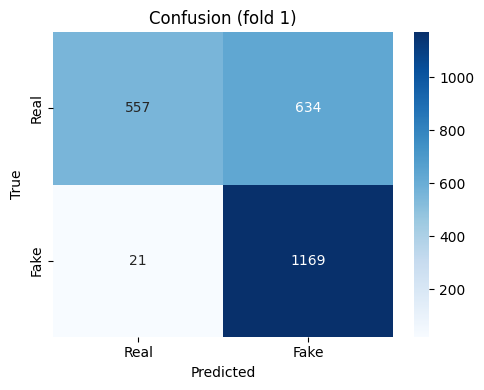

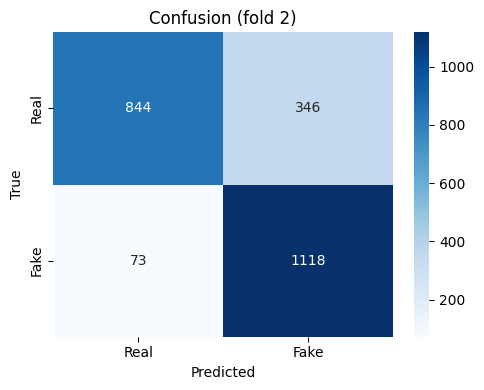

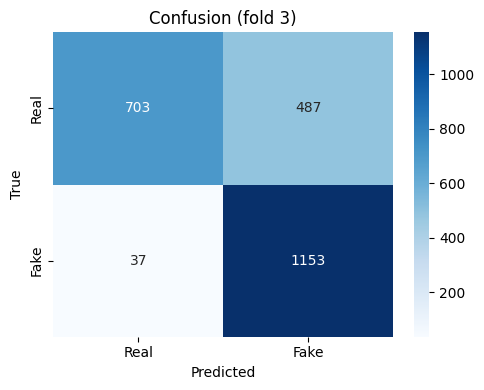

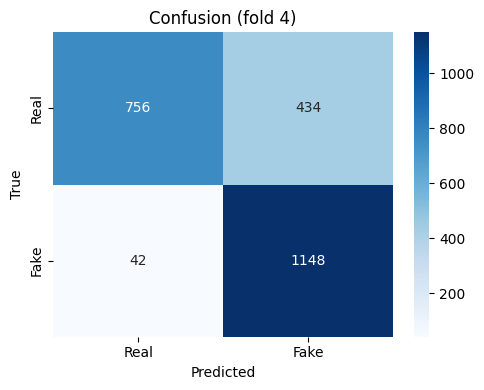

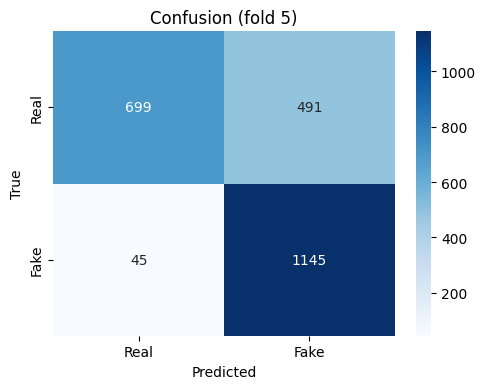


===== MÉTRICAS POR FOLD =====
   fold  accuracy  precision    recall        f1  log_loss
0     1  0.724906   0.648364  0.982353  0.781156  0.545035
1     2  0.824024   0.763661  0.938707  0.842185  0.521404
2     3  0.779832   0.703049  0.968908  0.814841  0.525420
3     4  0.800000   0.725664  0.964706  0.828283  0.522062
4     5  0.774790   0.699878  0.962185  0.810333  0.530481

===== MÉDIAS =====
fold         3.000000
accuracy     0.780710
precision    0.708123
recall       0.963372
f1           0.815359
log_loss     0.528881
dtype: float64

===== DESVIO PADRÃO =====
fold         1.581139
accuracy     0.036736
precision    0.042003
recall       0.015831
f1           0.022815
log_loss     0.009720
dtype: float64


In [ ]:
from sklearn import svm

model = svm.SVC(C=0.5, gamma='auto', kernel='sigmoid')

result = evaluate_model_cv(model, X, y)